# Sentiment Analysis of #TTC Tweets - Part 3 of 3

In the final component of this project we shall investigate TTC transit delay data and how it relates to tweets with the #TTC hashtag, continuing our study from Parts 1 and 2. The datasets of focus in this section contain an abundance of information pertaining to TTC bus, streetcar, and subway delays.

In Part 2 of this project we discovered much about TTC subway closures but somewhat disappointingly we noted that there was almost no relaion between scheduled subway closures and tweets with the #TTC hashtag. Does the situation change when we consider unplanned service disruptions instead? Let's find out!

## Importing Libraries

As always we begin by importing the required libraries.

In [32]:
# import libraries
import numpy as np # for arrays
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for data visualization
import datetime # for handling dates
from datetime import datetime as dt # also for dates
import calendar # also for dates
import string # for strings
import re # for regular expressions
from nltk.sentiment.vader import SentimentIntensityAnalyzer # for sentiment analysis
from nltk import tokenize # for tokenizing text
from scipy import stats # for statistics test
from statsmodels.stats.multitest import multipletests # for applying Holm-Bonferroni corrections
from wordcloud import WordCloud # for word clouds
import folium # for mapping
from folium.plugins import HeatMap # for heatmaps

# set preferences
sns.set_style('whitegrid')
%matplotlib inline
pd.set_option('display.max_colwidth', 400)

## Loading the Data

The [Toronto Open Data Portal](https://open.toronto.ca/) makes publicly available an abundance of information on all things Toronto. From this portal we can find data on TTC [bus](https://open.toronto.ca/dataset/ttc-bus-delay-data/), [streetcar](https://open.toronto.ca/dataset/ttc-streetcar-delay-data/), and [subway](https://open.toronto.ca/dataset/ttc-subway-delay-data/) delays. At the time of this writing, the data is available for the period from January 1, 2014 to June 30, 2021 which is why this particular range was selected for this project. I have already gone ahead and downloaded the data from the Open Data Portal so we need only load it in now. We shall store the data as three separate dataframes, one for each transit type. Note that the data contains a large number of entries which are not actually delays as they have recorded delay times of 0 minutes. Thus we immediately drop such entries as they are not useful to our analyses.

In [33]:
# initialize dictionary of delay dataframes
delays = dict()

# list of transit types
transit_types = ['bus', 'streetcar', 'subway']

# loop through transit types
for transit in transit_types:
    
    # load data
    delays[transit] = pd.read_csv('delays/{}_delays.csv'.format(transit), index_col = 0)
    
    # drop entries which are not delays
    delays[transit] = delays[transit][delays[transit]['Min Delay'] != 0]

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


As we will also need the Twitter data let's load that as well.

In [34]:
# load Twitter data
tweets = pd.read_csv('tweets/tweets_post_part_1.csv', index_col = 0)
tweets_per_day = pd.read_csv('tweets/tweets_per_day_post_part_1.csv', index_col = 0)

## Cleaning the Delay Data

Let's have a look at what sort of information is stored in our three delay dataframes.

In [35]:
# preview bus delay data
delays['bus'].head()

,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,Incident ID
0,2014-01-01,95,0:23:00,Wednesday,York Mills station,Mechanical,10.0,20.0,E,1734.0,NaN
1,2014-01-01,102,0:55:00,Wednesday,Entire run for route,General Delay,33.0,66.0,b/w,8110.0,NaN
2,2014-01-01,54,1:28:00,Wednesday,lawrence and Warden,Mechanical,10.0,20.0,WB,7478.0,NaN
3,2014-01-01,112,1:30:00,Wednesday,Kipling Station,Emergency Services,18.0,36.0,N,8084.0,NaN
4,2014-01-01,24,1:37:00,Wednesday,VP and Ellesmere,Investigation,10.0,20.0,n,7843.0,NaN


In [36]:
# bus delay features
delays['bus'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508062 entries, 0 to 515040
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Report Date  508062 non-null  object 
 1   Route        508032 non-null  object 
 2   Time         508062 non-null  object 
 3   Day          508062 non-null  object 
 4   Location     507317 non-null  object 
 5   Incident     507133 non-null  object 
 6   Min Delay    507598 non-null  float64
 7   Min Gap      507120 non-null  float64
 8   Direction    494257 non-null  object 
 9   Vehicle      439044 non-null  float64
 10  Incident ID  5120 non-null    float64
dtypes: float64(4), object(7)
memory usage: 46.5+ MB


In [37]:
# preview streetcar delay data
delays['streetcar'].head()

,Report Date,Route,Time,Day,Location,Incident,Min Delay,Min Gap,Direction,Vehicle,Incident ID
0,2014-01-02,505,06:31:00,Thursday,Dundas and Roncesvalles,Late Leaving Garage,4.0,8.0,E/B,4018.0,NaN
1,2014-01-02,504,12:43:00,Thursday,King and Shaw,Utilized Off Route,20.0,22.0,E/B,4128.0,NaN
2,2014-01-02,501,14:01:00,Thursday,Kingston road and Bingham,Held By,13.0,19.0,W/B,4016.0,NaN
3,2014-01-02,504,14:22:00,Thursday,King St. and Roncesvalles Ave.,Investigation,7.0,11.0,W/B,4175.0,NaN
4,2014-01-02,504,16:42:00,Thursday,King and Bathurst,Utilized Off Route,3.0,6.0,E/B,4080.0,NaN


In [38]:
# streetcar delay features
delays['streetcar'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90909 entries, 0 to 92948
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Report Date  90909 non-null  object 
 1   Route        90899 non-null  object 
 2   Time         90909 non-null  object 
 3   Day          90909 non-null  object 
 4   Location     90674 non-null  object 
 5   Incident     90908 non-null  object 
 6   Min Delay    90830 non-null  float64
 7   Min Gap      90788 non-null  float64
 8   Direction    89748 non-null  object 
 9   Vehicle      86418 non-null  float64
 10  Incident ID  869 non-null    float64
dtypes: float64(4), object(7)
memory usage: 8.3+ MB


In [39]:
# preview subway delay data
delays['subway'].head()

,Date,Time,Day,Station,Code,Min Delay,Min Gap,Bound,Line,Vehicle,Code Description
0,2014-01-01,00:21:00,Wednesday,VICTORIA PARK STATION,MUPR1,55,60,W,BD,5111,PRIORITY ONE - TRAIN IN CONTACT WITH PERSON
1,2014-01-01,02:06:00,Wednesday,HIGH PARK STATION,SUDP,3,7,W,BD,5001,DISORDERLY PATRON
3,2014-01-01,03:10:00,Wednesday,LANSDOWNE STATION,SUDP,3,8,W,BD,5116,DISORDERLY PATRON
4,2014-01-01,03:20:00,Wednesday,BLOOR STATION,MUSAN,5,10,S,YU,5386,UNSANITARY VEHICLE
12,2014-01-01,08:48:00,Wednesday,KIPLING STATION,MUNOA,5,0,E,BD,0,NO OPERATOR AVAILABLE - NON ESA RELATED


In [40]:
# subway delay features
delays['subway'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46450 entries, 0 to 143916
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Date              46450 non-null  object
 1   Time              46450 non-null  object
 2   Day               46450 non-null  object
 3   Station           46450 non-null  object
 4   Code              46450 non-null  object
 5   Min Delay         46450 non-null  int64 
 6   Min Gap           46450 non-null  int64 
 7   Bound             46000 non-null  object
 8   Line              46443 non-null  object
 9   Vehicle           46450 non-null  int64 
 10  Code Description  46450 non-null  object
dtypes: int64(3), object(8)
memory usage: 4.3+ MB


We can immediately note that there is a huge number of delays in our dataset. We have over 500 000 bus delays, 90 000 streetcar delays, and 46 000 subway delays over the course of seven and a half years! This amounts to an average of about 186 bus delays, 33 streetcar delays, and 17 subway delays everyday.

Let's run through the features in our datasets. We have

* **Report Date** (**Date** in the subway data) - the date of the delay
* **Route** (**Line** in the subway data) - the number of the bus/streetcar route or subway line
* **Time** - the time of the delay
* **Day** - day of the week on which the delay occurred
* **Location** (**Station** in the subway data) - location/subway station at which the delay occurred
* **Incident** (**Code Description** in the subway data) - a description of the incident which caused the delay
* **Min Delay** - the length of the delay in minutes
* **Min Gap** - the total time, in minutes, between the current bus/streetcar/train and the bus/streetcar/train immediately ahead
* **Direction** (**Bound** in the subway data) - direction of travel
* **Vehicle** - vehicle number
* **Incident ID** (only for the bus and streetcar data) - id of delay type; succinct version of **Incident**
* **Code** (only for the subway data) - TTC delay code; succinct version of **Code Description** and similar to **Incident ID**

We restructure the subway delay data to match up with the bus and streetcar datasets. In addition, since **Incident ID** and **Code** contain the same information as **Incident** and **Code Description**, respectively, we drop the **Incident ID** and **Code** features. The **Vehicle** feature will not be useful so we drop it as well.

In [41]:
# rename columns
delays['subway'].rename(columns = {'Date':'Report Date', 'Line':'Route', 'Station':'Location', 'Code Description':'Incident',
                                   'Bound':'Direction', 'Code':'Incident ID'}, inplace = True)


# column names from bus delay data
col_names = delays['bus'].columns

# reorder subway dataframe columns
delays['subway'] = delays['subway'][col_names]

# loop through transit types
for transit in transit_types:
    
    # drop features
    delays[transit].drop(['Incident ID', 'Vehicle'], axis = 1, inplace = True)

### **Report Date** and **Time**

We begin by converting the **Report Date** and **Time** features to datetime objects. We then extract the hour of the delay from the **Time** feature and then drop the **Time** feature since only the hour of the delay will be useful.

In [42]:
# loop through transit types
for transit in transit_types:
    
    # convert Report Date
    delays[transit]['Report Date'] = pd.to_datetime(delays[transit]['Report Date'], format = '%Y-%m-%d')
    delays[transit]['Report Date'] = delays[transit]['Report Date'].apply(lambda x: x.date())
    
    # extract hour
    delays[transit]['Hour'] = delays[transit]['Time'].apply(lambda x: dt.strptime(x, '%H:%M:%S').hour)
    
    # drop Time feature
    delays[transit].drop(['Time'], axis = 1, inplace = True)

### **Route**

Next we convert the **Route** feature to be integer-valued. We fill in missing values with a value of 0. A scan of the entries in the **Route** feature shows that in the bus and streetcar delay data, all values can naturally be converted to integers except one: 'RAD'.

The TTC uses the 'RAD' designation for buses/streetcars which "run as directed", i.e. vehicles which fill in any potential service gaps. We shall assign these vehicles a route number of 1000 since no such route number exists in the TTC.

In [43]:
# loop through transit types
for transit in transit_types:
    
    # restrict attention to bus and streetcar dataframes
    if transit != 'subway':
        
        # replace RAD with 1000
        delays[transit]['Route'].replace({'RAD':1000}, inplace = True)
    
        # fill missing values
        delays[transit]['Route'].fillna(0, inplace = True)
    
        # convert to integers
        delays[transit]['Route'] = delays[transit]['Route'].apply(int)

The situation for the subway data is a bit more complicated. Let's take a look at the unique **Route** values.

In [44]:
# print unique route values
print('Unique route values in the subway delay data:')
print(delays['subway']['Route'].unique())

Unique route values in the subway delay data:
['BD' 'YU' 'SHP' 'SRT' nan '25 DON MILLS' 'YU/BD' '66' 'B/D']


Values of 'YU', 'BD', 'SRT', and 'SHP' stand for Yonge-University Line 1, Bloor-Danforth Line 2, Scarborough Rapid Transit Line 3, and Sheppard Line 4, respectively. The entry 'B/D' is another way of representing Line 2. Let's replace these **Route** values with their respectve line number.

In [45]:
# replace values with corresponding line number
delays['subway'].replace('YU', 1, inplace = True)
delays['subway'].replace(('BD', 'B/D'), 2, inplace = True)
delays['subway'].replace('SRT', 3, inplace = True)
delays['subway'].replace('SHP', 4, inplace = True)

What to impute for **Route** values of '25 DON MILLS', 'YU/BD', and '66' is less clear. Let's have a look at the delays with these **Route** values.

In [46]:
# unusual Route values
delays['subway'][delays['subway']['Route'].isin(['25 DON MILLS', 'YU/BD', '66'])]

,Report Date,Route,Day,Location,Incident,Min Delay,Min Gap,Direction,Hour
32349,2015-07-22,25 DON MILLS,Wednesday,DON MILLS STATION,INJURED/ILL CUSTOMER IN STATION - TRANSPORTED,3,6,NaN,8
45796,2016-03-12,YU/BD,Saturday,MUSEUM STATION,SI SPEED CONTROL,3,7,S,21
57107,2016-09-22,66,Thursday,KENNEDY SRT STATION,DISORDERLY PATRON,12,17,N,12


Fortunately for us the **Location** feature tells us exactly what to impute for **Route**. Don Mills station is located along Line 4, Museum Station is on Line 1, and the Kennedy SRT Station is on Line 3.

In [47]:
# replace Route values
delays['subway'].loc[32349, 'Route'] = 4
delays['subway'].loc[45796, 'Route'] = 1
delays['subway'].loc[57107, 'Route'] = 3

We still need to impute missing **Route** values. We can try using the **Location** feature in the same way we did above.

In [48]:
# missing Route values
delays['subway'][delays['subway']['Route'].isna()]

,Report Date,Route,Day,Location,Incident,Min Delay,Min Gap,Direction,Hour
2246,2014-02-07,NaN,Friday,DUNDAS WEST STATION,SIGNALS TRACK WEATHER RELATED ISSUES,3,6,W,19
15761,2014-10-07,NaN,Tuesday,YONGE BD STATION,DOOR PROBLEMS RE:FAULTY EQUIPMENT,4,7,E,18
20423,2014-12-31,NaN,Wednesday,OLD MILL STATION,SIGNALS - TRACK CIRCUIT PROBLEMS,4,8,E,23
39519,2015-11-19,NaN,Thursday,FINCH STATION,MISCELLANEOUS OTHER,3,5,S,16
94597,2018-08-11,NaN,Saturday,GREENWOOD STATION,INJURED/ILL CUSTOMER ON TRAIN - TRANSPORTED,6,10,E,18
137181,2021-01-13,NaN,Wednesday,FINCH WEST STATION,UNSANITARY VEHICLE,3,6,S,15
138890,2021-02-22,NaN,Monday,BLOOR STATION,ASSUALT / PATRON INVOLVED,4,9,N,22


Dundas West Station, Old Mill Station, and Greenwood Station are on Line 2. Finch Station and Finch West Station are located on Line 1. The values 'YONGE BD STATION' and 'BLOOR STATION' refer to Bloor-Yonge Station which is located on Lines 1 and 2 so from the location alone the proper entry for **Route** is ambiguous. However, the delay with a **Route** value of 'YONGE BD STATION' occurred in the eastbound direction, as seen in the **DIrection** feature so it must have occurred on Line 2. Similarly, the delay with a **Route** value of 'BLOOR STATION' was in the northbound direction and thus occurred on Line 1.

In [49]:
# fill missing Route values
delays['subway'].loc[[39519, 137181, 138890], 'Route'] = 1
delays['subway']['Route'].fillna(2, inplace = True)

### **Location** and **Incident**

For these features we fill in the missing values with 'UNKNOWN'. To standardize the **Location** and **Incident** values we convert all entries to upper case.

In [50]:
# list of features to fill
loc_inc = ['Location', 'Incident']

# loop through transit types
for transit in transit_types:
    
    # loop through features
    for feat in loc_inc:
        
        # fill null values
        delays[transit][feat].fillna('UNKNOWN', inplace = True)
        
        # convert to uppercase
        delays[transit][feat] = delays[transit][feat].apply(lambda x: ' '.join(x.split()).upper())

The **Location** feature is certainly useful as it records the location of the delay. Unfortunately however there is no standardized way in which this data was recorded. For example, Russell Yard, also known as Russell Carhouse, is where the TTC stores and dispatches some of its streetcars and is located near the intersection of Queen St and Connaught Ave. Russell Yard appears in our dataset as "RUSSELL YARD", "RUSSEL CARHOUSE", "QUEEN AND CONNAUGHT", and "CONNAUGHT AND QUEEN", among others. To make the most out of the **Location** feature we would need to consolidate these various representations of Russell Yard but this particular example is just one of many. A huge number of locations are represented in multiple different ways and it would be rather time-consuming to try and appropriately aggregate everything. Since the **Location** feature is not central to our analyses we choose to perform minimal cleaning of this feature.

In the **Location** feature, abbreviations are sometimes used. Perhaps the most common is the usage of "STN" to mean "Station". Thus in the **Location** feature we replace "STN" with "STATION".

In [51]:
# loop through transit types
for transit in transit_types:

    # replace "STN" with "STATION"
    delays[transit]['Location'] = delays[transit]['Location'].apply(lambda x: re.sub(' STN', ' STATION', x))

### **Min Delay** and **Min Gap**

The **Min Delay** feature is the most important in our dataset, recording the total time of each delay. The **Min Gap** feature is less useful as it just records the sum of the total delay time and the expected wait time. For example, if a bus is supposed to arrive every 10 minutes but it gets delayed by 15 minutes then this would be recorded as a **Min Delay** time of 15 minutes and a **Min Gap** time of 25 minutes. Hence there is a lot of redundancy in these two features and so we will ultimately drop the **Min Gap** feature. We keep the **Min Gap** feature for now however as it will help us clean **Min Delay**.

In the bus delay data, some rows have negative values for **Min Delay** and/or **Min Gap**, which is impossible. The streetcar and subway delay datasets have no such peculiarity.

In [52]:
# bus delays with negative Min Delay or Min Gap values
delays['bus'][(delays['bus']['Min Delay'] < 0) | (delays['bus']['Min Gap'] < 0)]

,Report Date,Route,Day,Location,Incident,Min Delay,Min Gap,Direction,Hour
7357,2014-01-24,11,Friday,BAYVIEW AND FIFE,INVESTIGATION,-1.0,15.0,M,14
74106,2014-10-08,105,Wednesday,DOWMSVOEW STATION,GENERAL DELAY,35.0,-2.0,b/w,18
149849,2015-09-18,103,Friday,MTPLEASANT NORTH RTE.,GENERAL DELAY,-20.0,40.0,b/w,14
319733,2018-01-08,30,Monday,MABELLE AND DUNDAS,GENERAL DELAY,-30.0,45.0,B/W,6
327433,2018-02-10,102,Saturday,WSTN,UTILIZED OFF ROUTE,-10.0,20.0,N/B,18
357978,2018-07-11,48,Wednesday,RATHBURN AND RENFORTH,GENERAL DELAY,-20.0,30.0,B/W,16
366403,2018-08-21,110,Tuesday,LONGBRANCH,LATE LEAVING GARAGE,-10.0,20.0,N/B,5
376577,2018-10-10,952,Wednesday,LAWRENCE STATION TO TERMINAL 3,GENERAL DELAY,-54.0,66.0,B/W,15
386399,2018-11-28,49,Wednesday,AUXLAND AND DUNDAS,DIVERSION,-10.0,20.0,N/B,16
391829,2018-12-30,300,Sunday,BETWEEN T3 AND KENNEDY STATION,GENERAL DELAY,-20.0,36.0,B/W,2


A reasonable asumption is that these values are correct in magnitude but incorrect in sign. We fix this by applying the absolute value to the **Min Delay** and **MinGap** features.

In [53]:
# convert to positive values
delays['bus']['Min Delay'] = delays['bus']['Min Delay'].apply(abs)
delays['bus']['Min Gap'] = delays['bus']['Min Gap'].apply(abs)

The bus and streetcar datasets have some missing values for **Min Delay** and **Min Gap**.

In [54]:
# display percentage of missing Min Delay and Min Gap data
for transit in transit_types:
        
    # calculate percentage of data which is missing
    delay_missing = round(100 * sum(delays[transit]['Min Delay'].isnull()) / delays[transit].shape[0], 3)
    gap_missing = round(100 * sum(delays[transit]['Min Gap'].isnull()) / delays[transit].shape[0], 3)
    
    # print percentage of missing data
    print('\n')
    print('Percentage of missing "Min Delay" data in the {} delay dataset: {}%'.format(transit, delay_missing))
    print('Percentage of missing "Min Gap" data in the {} delay dataset: {}%'.format(transit, gap_missing))



Percentage of missing "Min Delay" data in the bus delay dataset: 0.091%
Percentage of missing "Min Gap" data in the bus delay dataset: 0.185%


Percentage of missing "Min Delay" data in the streetcar delay dataset: 0.087%
Percentage of missing "Min Gap" data in the streetcar delay dataset: 0.133%


Percentage of missing "Min Delay" data in the subway delay dataset: 0.0%
Percentage of missing "Min Gap" data in the subway delay dataset: 0.0%


We shall impute the missing **Min Delay** values but to accurately do so we first perfrom some preliminary data exploration.

In [26]:
# summary statistics of bus Min Delay and Min Gap
delays['bus'][['Min Delay', 'Min Gap']].describe([0.25, 0.5, 0.75, 0.98])

,Min Delay,Min Gap
count,507598.000000,507120.000000
mean,20.330214,30.180689
std,352.807422,72.120555
min,1.000000,0.000000
25%,7.000000,12.000000
50%,10.000000,20.000000
75%,16.000000,30.000000
98%,97.000000,120.000000
max,246245.000000,6528.000000


In [27]:
# summary statistics of streetcar Min Delay and Min Gap
delays['streetcar'][['Min Delay', 'Min Gap']].describe([0.25, 0.5, 0.75, 0.98])

,Min Delay,Min Gap
count,90830.000000,90788.000000
mean,13.287625,19.106049
std,32.204743,34.963697
min,1.000000,0.000000
25%,5.000000,10.000000
50%,7.000000,12.000000
75%,11.000000,20.000000
98%,70.000000,76.000000
max,1400.000000,4216.000000


There are some pretty extreme outliers in the dataset. Indeed, 98% of bus delays lasted at most 95 minutes but apparently there was a bus delay that lasted roughly five and a half months! There is no way that such extreme values are accurate. Let's take a look at the bus delays that supposedly lasted over a day.

In [28]:
# bus delays that lasted over a day
delays['bus'][delays['bus']['Min Delay'] > 1440]

,Report Date,Route,Day,Location,Incident,Min Delay,Min Gap,Direction,Hour
15286,2014-02-19,73,Wednesday,ALBION & ISLINGTON,DIVERSION,3780.0,398.0,S,18
18114,2014-03-01,41,Saturday,WEST TORONTO AND KEELE,DIVERSION,246245.0,260.0,b/w,20
21617,2014-03-13,108,Thursday,TUSCAN GATE AND SHEPPARD AVE WEST,DIVERSION,1900.0,208.0,E,10
63340,2014-09-02,172,Tuesday,PARLIAMENT AND FRONT,DIVERSION,2430.0,2650.0,w,10
76429,2014-10-18,6,Saturday,BAY ROUTE 6,DIVERSION,1543.0,1553.0,BW,12
87495,2014-11-30,73,Sunday,LAROSE AND SCARLETT RD,DIVERSION,3380.0,368.0,S,14
112928,2015-03-19,32,Thursday,EGLINTON AND RICHARDSON,DIVERSION,5775.0,5783.0,b/w,5
121329,2015-04-29,89,Wednesday,WESTON AND WALSH AVE,DIVERSION,1623.0,1641.0,NB,21
198418,2016-05-25,191,Wednesday,HIGHWAY 27 AT REXDALE BLVD.,DIVERSION,2030.0,210.0,N/B,6
211327,2016-07-23,63,Saturday,DUNDAS TO QUEEN,DIVERSION,2422.0,10.0,BW,6


It is incredibly unlikely that a delay lasts more than a day and there is absolutely no way that a delay lasts nearly six months! This was supposedly the case on March 3, 2014 for a bus on Route 41. Based off the **Min Delay** value of 246245 minutes and **Min Gap** value of 260 minutes, it seems much more likely that the **Min Delay** was misreported and should probably be 245 instead.

In [55]:
# index of extreme value
ind = delays['bus'][delays['bus']['Min Delay'] == delays['bus']['Min Delay'].max()].index

# replace value
delays['bus'].loc[ind, 'Min Delay'] = 245

Many other extreme values also seem rather inflated, especially relative to their corresponding **Min Gap** quantity. However, it is difficult to accurately estimate what their values should be. Since it is a near certainty that delays do not last longer than 24 hours and since only a relatively small portion of the dataset exhibits such extreme behaviour, we shall impose a 24 hour upper maximum to **Min Delay** values. This upper limit is only required for the bus delay dataset as the other two datasets do not exhibit such extreme behaviour.

In [56]:
# impose 24 hour limit
delays['bus']['Min Delay'] = delays['bus']['Min Delay'].apply(lambda x: min(x, 1440))

Now to actually impute the missing values. Since so few entries are missing it is safe to impute the missing values via the median.

In [57]:
# loop through transit types
for transit in transit_types:
    
    # calculate median
    med = delays[transit]['Min Delay'].median()
    
    # fill missing values
    delays[transit]['Min Delay'].fillna(med, inplace = True)

As it is no longer needed we drop the **Min Gap** feature.

In [58]:
# loop through transit types
for transit in transit_types:
    
    # drop Min Gap
    delays[transit].drop(['Min Gap'], axis = 1, inplace = True)

### **Direction**

The **Direction** feature was helpful in cleaning the subway dataset's **Route** feature but we no longer need it. Thus we go ahead and drop this feature.

In [59]:
# loop through transit types
for transit in transit_types:
    
    # drop feature
    delays[transit].drop(['Direction'], axis = 1, inplace = True)

## Cleaning the Twitter Data

The Twitter data was cleaned in Part 1 of this project. However, when we loaded in the data all datetime objects were converted to strings. Just like in Part 2 we convert the appropriate features back to datetime objects.

In [60]:
# Twitter dataframes
twitter_dfs = [tweets, tweets_per_day]

# loop through dataframes
for df in twitter_dfs:

    # convert to datetime
    df['date'] = pd.to_datetime(df['date'], format = '%Y-%m-%d')

    # extract just the day
    df['date'] = df['date'].apply(lambda x: x.date())

## Exploring the Delay Data

Before we delve into the relationship between #TTC tweets and TTC delays we should first analyze the delay data on its own.

### Daily Delay Numbers

Let's start by having a look at the number of bus, streetcar, and subway delays per day.

In [61]:
# initialize dictionary to store daily delays
delays_per_day = dict()

# list of columns to append to tweets_per_day dataframe
delay_cols = ['{}Delays'.format(transit) for transit in transit_types]

# columns of the soon-to-be-merged tweets_per_day dataframe
new_cols = tweets_per_day.columns.to_list() + delay_cols

# loop through transit types
for transit in transit_types:

    # counts per day
    delays_per_day[transit] = delays[transit].groupby('Report Date').count()['Route'].reset_index()

    # rename column
    delays_per_day[transit].columns = ['Report Date', 'numDelays']

    # assign a count of 0 to dates without tweets
    for date in pd.date_range(dt(2014, 1, 1), dt(2021, 6, 30)):
        if date.date() not in delays_per_day[transit]['Report Date'].values:
            temp_df = pd.DataFrame(data = {'Report Date':[date.date()], 'numDelays':[0]})
            delays_per_day[transit] = pd.concat([delays_per_day[transit], temp_df])

    # reset index
    delays_per_day[transit].reset_index(inplace = True, drop = True)

    # sort by date
    delays_per_day[transit].sort_values('Report Date', inplace = True)
    
    # merge dataframes
    tweets_per_day = pd.merge(tweets_per_day, delays_per_day[transit], left_on = 'date',
                              right_on = 'Report Date').drop(['Report Date'], axis = 1)
    
# rename columns
tweets_per_day.columns = new_cols

# important dates
covid = dt(2020, 3, 17)
snow_1 = dt(2019, 1, 29)
snow_2 = dt(2014, 12, 11)
cold_1 = dt(2017, 12, 28)
cold_feb_start = dt(2015, 2, 1)
cold_feb_end = dt(2015, 2, 28)

# y-axis range
ylims = {'bus':[0, 700], 'streetcar':[0, 160], 'subway':[0, 60]}

# initialize figure
plt.figure(figsize = (18, 18))
i = 1
alpha = 0.4

# loop through transit types
for transit in transit_types:
    
    # make plot
    plt.subplot(3, 1, i)
    fig = sns.lineplot(data = tweets_per_day, x = 'date', y = '{}Delays'.format(transit), color = 'g')
    fig.set(title = 'Daily Number of {} Delays'.format(transit.capitalize()), xlabel = 'Year',
            ylabel = 'Number of {} Delays'.format(transit.capitalize()), xlim = [dt(2014, 1, 1), dt(2021, 7, 1)],
            ylim = ylims[transit])
    plt.axvline(snow_1, color = 'black', label = 'Heavy snowfall', ls = '--', alpha = alpha)
    plt.axvline(snow_2, color = 'black', ls = '--', alpha = alpha)
    plt.axvline(cold_1, color = 'b', label = 'Extreme cold weather alert', ls = '--', alpha = alpha)
    plt.axvline(covid, color = 'r', label = 'Ontario declares state of emergency due to the COVID-19 pandemic', ls = '--',
                alpha = alpha)
    plt.axvline(cold_feb_start, color = 'orange', ls = '--', alpha = alpha)
    plt.axvline(cold_feb_end, color = 'orange', ls = '--', alpha = alpha)
    fig.axvspan(cold_feb_start, cold_feb_end, alpha = alpha, color = 'orange', label = 'Record Cold February')
    plt.legend(bbox_to_anchor = (0.18, 0.75))
    
    # increment counter
    i += 1
    
# display plots
plt.show()

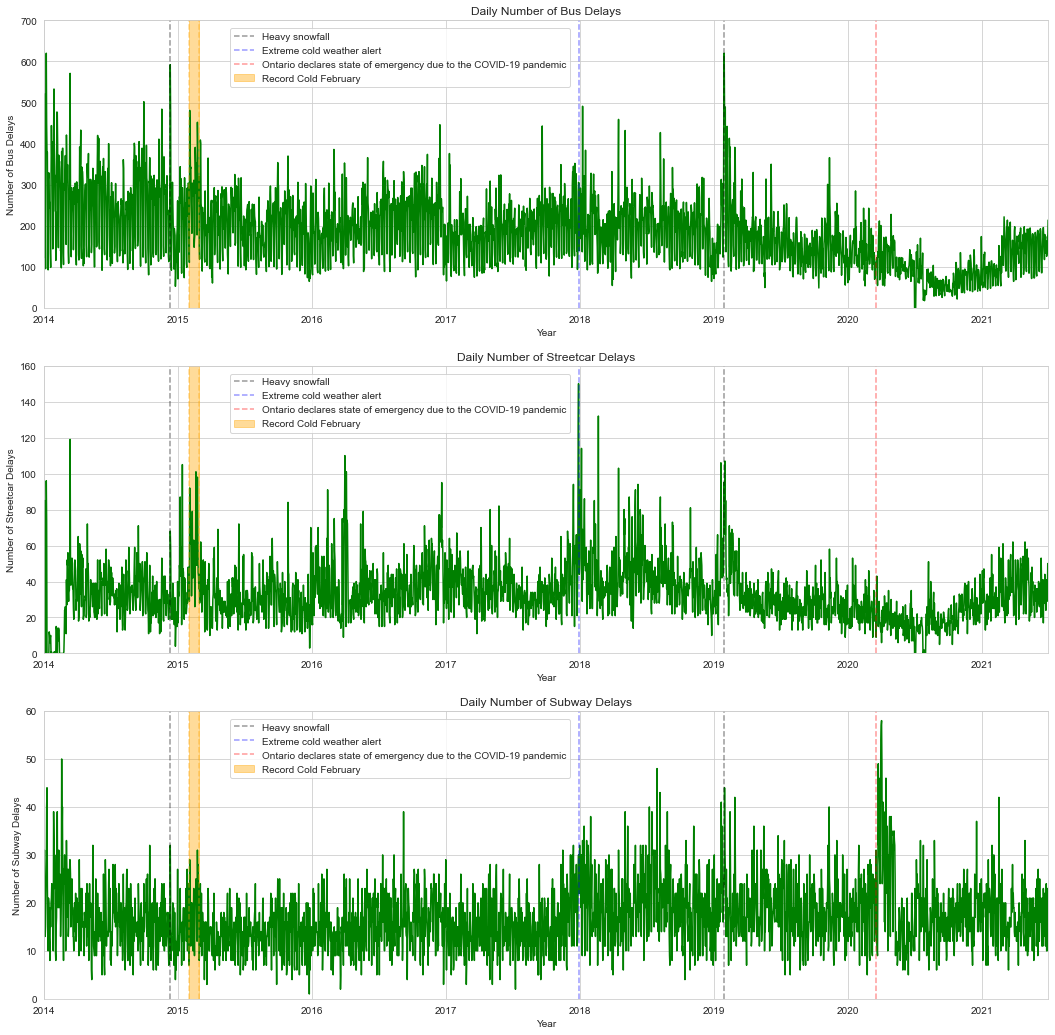

The graphs above convey some rather interesting tidbits of information. One thing of note is there has been a subway delay every single day since the start of our dataset, which I suppose is not all too surprising.

Secondly, inclement weather seems to affect the number of delays. It [snowed heavily](https://toronto.citynews.ca/2014/12/11/long-day-of-snow-a-headache-for-gta-drivers/) on December 11, 2014 and January 29, 2019 was the day after a [record-breaking snowfall](https://toronto.citynews.ca/2019/01/29/toronto-record-breaking-snowfall/) (this snowfall also led to drastically fewer parking tickets as discussed in my other project in which I [analyze Toronto parking tickets](https://github.com/ssorkhou/parking_tickets/blob/main/An_Analysis_of_Toronto_Parking_Tickets.ipynb)). On [December 28, 2017](https://toronto.citynews.ca/2017/12/28/freezing-toronto-temperatures-50-year-record-low/) Toronto experienced record-breaking cold temperatures. These dates correspond to significant spikes in the plots above. Such peaks however are far less pronounced in the subway data, likely due to the fact that most of the subway system is underground and thus largely unaffected by poor weather.

The bus and streetcar systems look to have had a higher than normal number of delays in February 2015. During this entire month [Toronto experienced brutally cold temperatures](https://www.thestar.com/news/starweather/2015/03/it-s-official-february-was-toronto-s-coldest-month-ever.html), tying a temperature record set in 1875. A box plot better visualizes the increase in delays during this month.

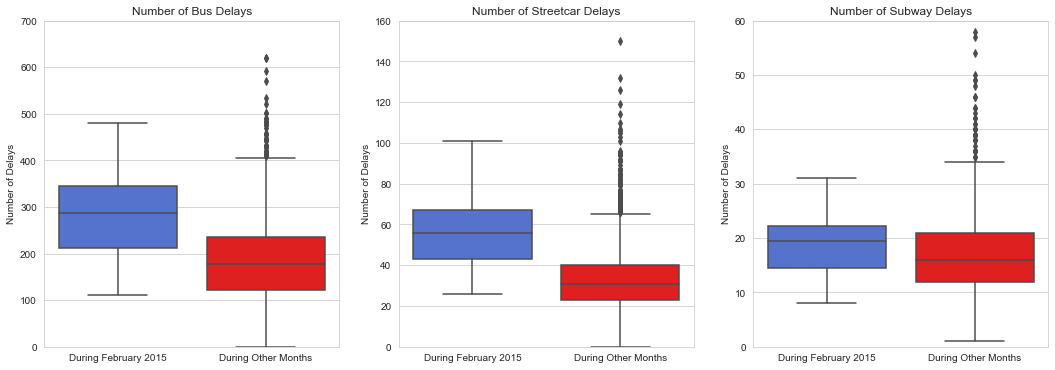

In [63]:
# Boolean recording whether it is February 2015
tweets_per_day['coldFeb'] = tweets_per_day['date'].apply(lambda x: 1 * ((x.year == 2015) and (x.month == 2)))

# y-axis range
ylims = {'bus':[0, 700], 'streetcar':[0, 160], 'subway':[0, 60]}

# initialize figure
plt.figure(figsize = (18, 6))
i = 1

# loop through transit types
for transit in transit_types:
    
    # make plot
    plt.subplot(1, 3, i)
    fig = sns.boxplot(data = tweets_per_day, x = 'coldFeb', y = '{}Delays'.format(transit), order = [1, 0],
                      palette = {1:'royalblue', 0:'r'})
    fig.set(title = 'Number of {} Delays'.format(transit.capitalize()), xlabel = '', ylabel = 'Number of Delays',
            ylim = ylims[transit], xticklabels = ['During February 2015', 'During Other Months'])
    
    # increment counter
    i += 1
    
# display plots
plt.show()

It does seem as though there was a substantial increase in the number of delays in February 2015 versus the rest of the dataset, at least for buses and streetcars. Let's apply Welch's t-tests to be sure.

In [64]:
# loop through transit types
for transit in transit_types:

    # number of delays
    a = tweets_per_day[tweets_per_day['coldFeb'] == 0]['{}Delays'.format(transit)]
    b = tweets_per_day[tweets_per_day['coldFeb'] == 1]['{}Delays'.format(transit)]

    # apply Welch's t-test
    pval = stats.ttest_ind(a, b, equal_var = False).pvalue

    # print p-value
    print('\n')
    print("Welch's t-test p-value for {} delays: {:.2e}".format(transit, pval))



Welch's t-test p-value for bus delays: 4.80e-06


Welch's t-test p-value for streetcar delays: 5.50e-07


Welch's t-test p-value for subway delays: 2.27e-01


From the Welch's t-tests we can conclude that for buses and streetcars the difference between the mean number of transit delays in February 2015 and the mean number of delays in other months is statistically significant. We find that during February 2015 there were on average 287 bus delays and 57 streetcar delays while averaging over all other months yields 185 bus delays and 33 streetcar delays daily. The fact that our difference is not statistically significant for the subway data is unsurprising given the subway system's general indifference to weather.

The third observation we can draw from the plots of daily transit delays over time is that the COVID-19 pandemic looks to have had an impact on transit delays. Indeed, for buses and streetcars the number of delays drops once the pandemic sets in and then slowly rises to pre-pandemic levels. By contrast, there is temporarily a steep *increase* in the number of subway delays immediately after the state of emergency declaration due to COVID-19.

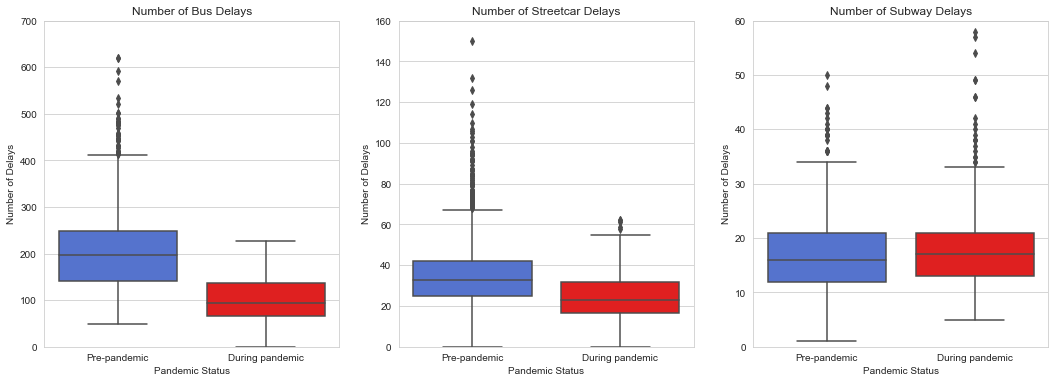

In [66]:
# initialize figure
plt.figure(figsize = (18, 6))
i = 1

# loop through transit types
for transit in transit_types:
    
    # make plot
    plt.subplot(1, 3, i)
    fig = sns.boxplot(data = tweets_per_day, x = 'pandemic', y = '{}Delays'.format(transit), palette = {0:'royalblue', 1:'r'})
    fig.set(title = 'Number of {} Delays'.format(transit.capitalize()), xlabel = 'Pandemic Status', ylabel = 'Number of Delays',
            ylim = ylims[transit], xticklabels = ['Pre-pandemic', 'During pandemic'])
    
    # increment counter
    i += 1
    
# display plots
plt.show()

For buses and streetcars we find that the number of delays before the pandemic was generally higher than the number of delays during the pandemic. To bring some numbers into it, before the pandemic there were on average 203 bus delays and 35 streetcar delaysper day whereas during the pandemic we have a daily average of 102 bus delays and 25 streetcar delays. This is a rather substantial effect size for the bus and streetcar systems. Curiously, the number of daily subway delays during the pandemic appears slightly *higher* than the pre-pandemic figures.

Let's ensure that our differences are statistically significant via Welch's t-tests.

In [67]:
# loop through transit types
for transit in transit_types:

    # restrict attention to buses and streetcars
    if transit != 'subway':
    
        # number of delays
        a = tweets_per_day[tweets_per_day['pandemic'] == 0]['{}Delays'.format(transit)]
        b = tweets_per_day[tweets_per_day['pandemic'] == 1]['{}Delays'.format(transit)]

        # apply Welch's t-test
        pval = stats.ttest_ind(a, b, equal_var = False).pvalue

        # print p-value
        print('\n')
        print("Welch's t-test p-value for {} delays: {:.2e}".format(transit, pval))



Welch's t-test p-value for bus delays: 5.93e-192


Welch's t-test p-value for streetcar delays: 2.12e-46


The Welch's t-tests suggest quite strongly that the differences between the pre-pandemic and during-pandemic numbers are statistically significant.

The TTC has reduced ridership on weekends and this likely led to the lower number of weekend tweets as discussed in Part 1. This should also lead to a lower number of weekend delays so let's see if this is true.

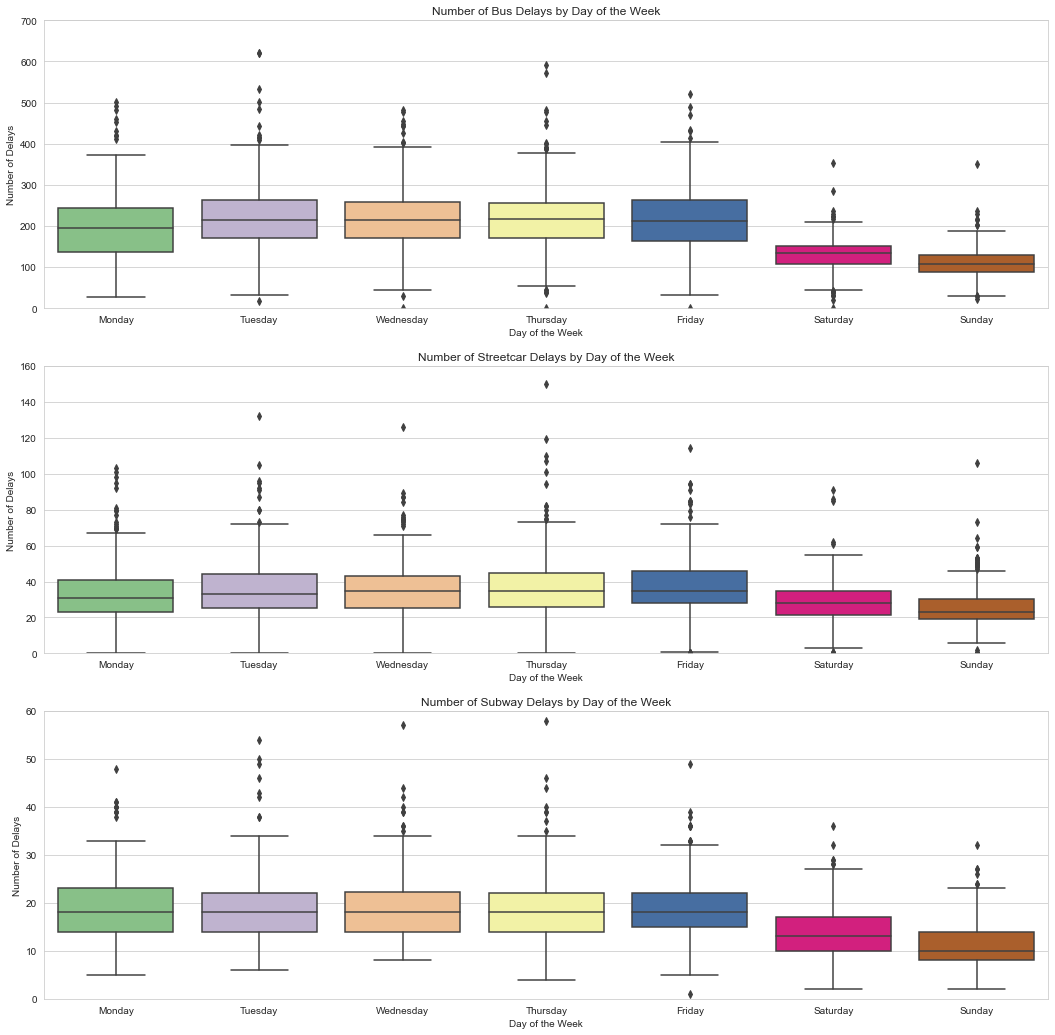

In [68]:
# initialize figure
plt.figure(figsize = (18, 18))
i = 1

# day labels
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# loop through transit types
for transit in transit_types:

    # make plot
    plt.subplot(3, 1, i)
    fig = sns.boxplot(data = tweets_per_day, x = 'dayOfWeek', y = '{}Delays'.format(transit), order = days, palette = 'Accent')
    fig.set(title = 'Number of {} Delays by Day of the Week'.format(transit.capitalize()), xlabel = 'Day of the Week',
            ylabel = 'Number of Delays', ylim = ylims[transit])
    
    # increment counter
    i += 1
    
# display plots
plt.show()

As anticipated, the number of delays in all three transit types appear reduced on weekends. Let's check for the existence of a statistically significant difference between the groups using a Kruskal-Wallis H-test.

In [69]:
# initialize dictionary of delay counts
count_by_weekday = {'bus':dict(), 'streetcar':dict(), 'subway':dict()}

# loop through transit types
for transit in transit_types:
    
    # loop through days
    for day in days:
    
        # store delay counts
        count_by_weekday[transit][day] = tweets_per_day[tweets_per_day['dayOfWeek'] == day]['{}Delays'.format(transit)]
    
    # perform Kruskal-Wallis H-test
    pval = stats.kruskal(count_by_weekday[transit][days[0]], count_by_weekday[transit][days[1]],
                         count_by_weekday[transit][days[2]], count_by_weekday[transit][days[3]],
                         count_by_weekday[transit][days[4]], count_by_weekday[transit][days[5]],
                         count_by_weekday[transit][days[6]]).pvalue

    # print p-value
    print('\n')
    print('Kruskal-Wallis H-test p-value for {} delays: {:.2e}'.format(transit, pval))



Kruskal-Wallis H-test p-value for bus delays: 3.00e-180


Kruskal-Wallis H-test p-value for streetcar delays: 5.41e-52


Kruskal-Wallis H-test p-value for subway delays: 9.95e-126


Thus there is indeed a statistically significant difference between days of the week when determining the number of delays per day. We use Welch's t-tests with a Holm-Bonferroni correction to ascertain which pairs have statistically significant differences.

In [70]:
# loop through transit types
for transit in transit_types:

    # initialize list of day-pairs and p-values
    pairs = []
    pvals = []

    # loop through all pairs of days
    for i in days:
        for j in days:
            if i < j:
            
                # compute p-value
                pval = stats.ttest_ind(count_by_weekday[transit][i], count_by_weekday[transit][j], equal_var = False).pvalue
            
                # append day-pair and p-value
                pairs.append((i, j))
                pvals.append(pval)
            
    # initialize list to store pairs with statistically significant differences
    diff_pairs = []

    # apply Holm-Bonferroni correction
    hb = multipletests(pvals, method = 'holm')[0]

    # loop through day-pairs
    for i in range(len(pairs)):
    
        # check for pairs with statistically significant differences
        if hb[i]:
        
            # append to list of pairs
            diff_pairs.append(pairs[i])
        
    # print pairs with statistically significant differences
    print('\n')
    print('Pairs of days with statistically significant differences for the {} data:'.format(transit))
    for pair in diff_pairs:
        print(pair)



Pairs of days with statistically significant differences for the bus data:
('Monday', 'Tuesday')
('Monday', 'Wednesday')
('Monday', 'Thursday')
('Monday', 'Saturday')
('Monday', 'Sunday')
('Friday', 'Monday')
('Friday', 'Saturday')
('Friday', 'Sunday')
('Saturday', 'Tuesday')
('Saturday', 'Wednesday')
('Saturday', 'Thursday')
('Saturday', 'Sunday')
('Sunday', 'Tuesday')
('Sunday', 'Wednesday')
('Sunday', 'Thursday')


Pairs of days with statistically significant differences for the streetcar data:
('Monday', 'Saturday')
('Monday', 'Sunday')
('Friday', 'Monday')
('Friday', 'Saturday')
('Friday', 'Sunday')
('Saturday', 'Tuesday')
('Saturday', 'Wednesday')
('Saturday', 'Thursday')
('Saturday', 'Sunday')
('Sunday', 'Tuesday')
('Sunday', 'Wednesday')
('Sunday', 'Thursday')


Pairs of days with statistically significant differences for the subway data:
('Monday', 'Saturday')
('Monday', 'Sunday')
('Friday', 'Saturday')
('Friday', 'Sunday')
('Saturday', 'Tuesday')
('Saturday', 'Wednesday')
(

We indeed find that the differences are statistically significant. In fact, we can conclude that on average, for all three transit types the average number of daily delays on weekdays is higher than the number of daily delays on Saturdays, which in turn is higher than the number of daily Sunday delays. We find that on average there are

* 212 daily bus delays, 36 daily streetcar delays, and 19 daily subway delays on weekdays,
* 130 daily bus delays, 29 daily streetcar delays, and 14 daily subway delays on Saturdays,
* and 110 daily bus delays, 25 daily streetcar delays, and 11 daily subway delays on Sundays.

### Daily Delay Times

We can repeat our analyses but instead of considering the daily number of delays we can examine the total daily delay time.

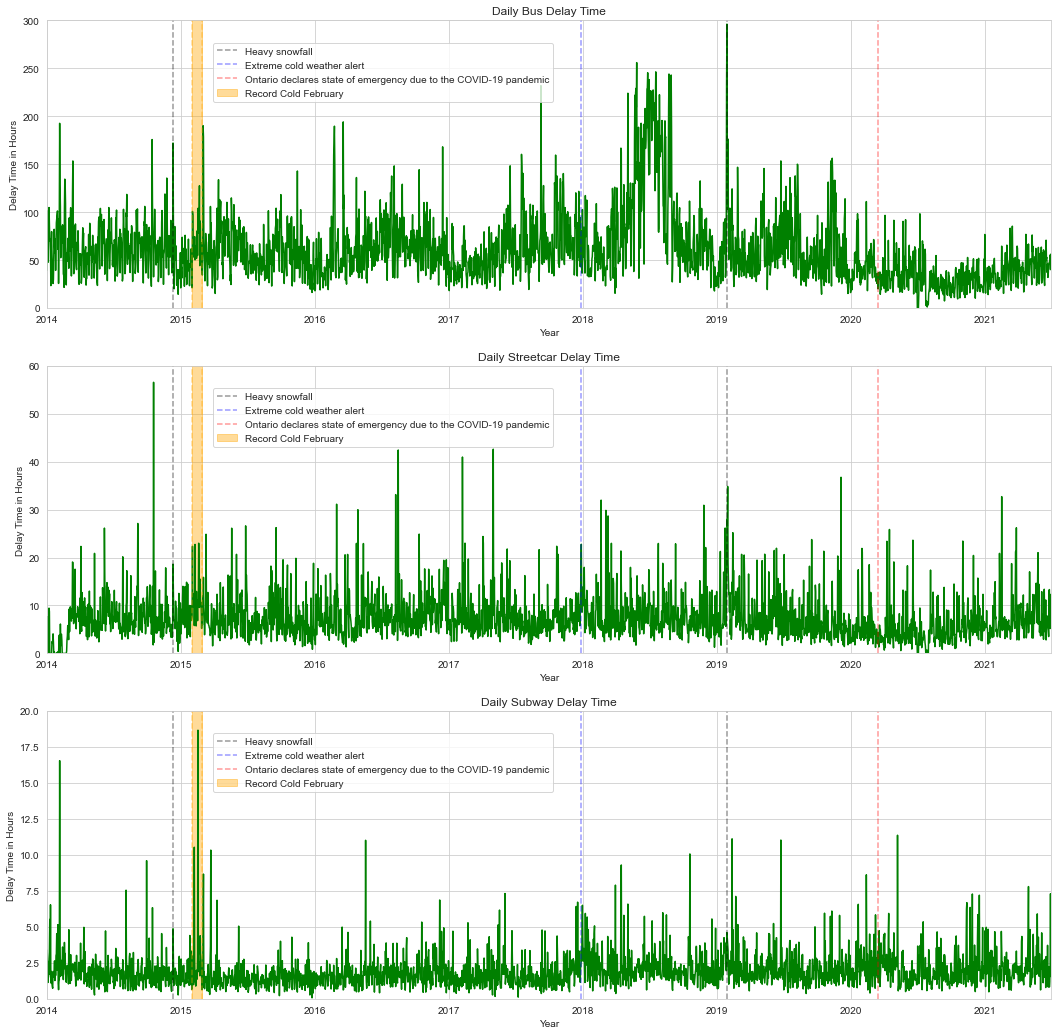

In [71]:
# initialize dictionary to store daily delay time
time_per_day = dict()

# list of columns to append to tweets_per_day dataframe
time_cols = ['{}Time'.format(transit) for transit in transit_types]

# columns of the soon-to-be-merged tweets_per_day dataframe
new_cols = tweets_per_day.columns.to_list() + time_cols

# loop through transit types
for transit in transit_types:

    # delay times by date
    time_per_day[transit] = delays[transit].groupby('Report Date').sum()['Min Delay'].reset_index()

    # rename column
    time_per_day[transit].columns = ['Report Date', 'delayTime']
    
    # convert to hours
    time_per_day[transit]['delayTime'] /= 60

    # assign a total delay time of 0 to dates without tweets
    for date in pd.date_range(dt(2014, 1, 1), dt(2021, 6, 30)):
        if date.date() not in time_per_day[transit]['Report Date'].values:
            temp_df = pd.DataFrame(data = {'Report Date':[date.date()], 'delayTime':[0]})
            time_per_day[transit] = pd.concat([time_per_day[transit], temp_df])

    # reset index
    time_per_day[transit].reset_index(inplace = True, drop = True)

    # sort by date
    time_per_day[transit].sort_values('Report Date', inplace = True)
    
    # merge dataframes
    tweets_per_day = pd.merge(tweets_per_day, time_per_day[transit], left_on = 'date',
                 right_on = 'Report Date').drop(['Report Date'], axis = 1)
    
# rename columns
tweets_per_day.columns = new_cols

# y-axis range
ylims = {'bus':[0, 300], 'streetcar':[0, 60], 'subway':[0, 20]}

# initialize figure
plt.figure(figsize = (18, 18))
i = 1

# loop through transit types
for transit in transit_types:
    
    # make plot
    plt.subplot(3, 1, i)
    fig = sns.lineplot(data = tweets_per_day, x = 'date', y = '{}Time'.format(transit), color = 'g')
    fig.set(title = 'Daily {} Delay Time'.format(transit.capitalize()), xlabel = 'Year',
            ylabel = 'Delay Time in Hours'.format(transit.capitalize()), xlim = [dt(2014, 1, 1), dt(2021, 7, 1)],
            ylim = ylims[transit])
    plt.axvline(snow_1, color = 'black', label = 'Heavy snowfall', ls = '--', alpha = alpha)
    plt.axvline(snow_2, color = 'black', ls = '--', alpha = alpha)
    plt.axvline(cold_1, color = 'b', label = 'Extreme cold weather alert', ls = '--', alpha = alpha)
    plt.axvline(covid, color = 'r', label = 'Ontario declares state of emergency due to the COVID-19 pandemic', ls = '--',
                alpha = alpha)
    plt.axvline(cold_feb_start, color = 'orange', ls = '--', alpha = alpha)
    plt.axvline(cold_feb_end, color = 'orange', ls = '--', alpha = alpha)
    fig.axvspan(cold_feb_start, cold_feb_end, alpha = alpha, color = 'orange', label = 'Record Cold February')
    plt.legend(bbox_to_anchor = (0.16, 0.7))
    
    # increment counter
    i += 1
    
# display plots
plt.show()

We observe some different behaviour when we consider total delay time in lieu of number of delays. Inclement weather does appear to have an impact and many of the days with high total delay times do occur on days with heavy snow or extremely cold temperatures. However, if we look through the days with the highest delay times we do not seem to find much correspondence to weather issues, or to anything for that matter.

One thing that is difficult to ignore is the rather wide and tall peak in the plot of daily bus delay time around the summer of 2018. What happened here? Whatever caused this abrupt increase in delay time seems to only have affected buses since there is no noticeable increase in the streetcar or subway data. In the plot of the number of bus delays there was no observable increase during this time either which suggests that for some reason delays got longer during this time.

I am not too sure what may be the cause of this peak but I suspect that the **Min Delay** values during that time period are incorrect. Indeed, during the time between May 26, 2018 and August 6, 2018, many delays were reported to last 999 minutes.

In [72]:
# bus delays during the peak in 2018
peak_2018 = delays['bus'][(delays['bus']['Report Date'] >= dt(2018, 5, 26).date())
                         & (delays['bus']['Report Date'] <= dt(2018, 8, 6).date())]

# bus delays during that peak with 999 minute delay time
peak_999 = peak_2018[peak_2018['Min Delay'] == 999]

# percentage of peak time delays with 999 minute delay time
perc_peak = 100 * peak_999.shape[0] / peak_2018.shape[0]

# print percentage
print('Percentage of bus delays between May 26, 2018 and August 6, 2018, with a 999 minute delay time: {}%'.format(round(perc_peak,
                                                                                                                         3)))

# percentage of all delays with 999 minute delay time
perc_tot = 100 * delays['bus'][delays['bus']['Min Delay'] == 999].shape[0] / delays['bus'].shape[0]

# print percentages
print('Percentage of all bus delays with a 999 minute delay time: {}%'.format(round(perc_tot, 3)))

Percentage of bus delays between May 26, 2018 and August 6, 2018, with a 999 minute delay time: 3.1%
Percentage of all bus delays with a 999 minute delay time: 0.241%


As we can see, the proportion of delays with a 999 minute delay time during this period is far higher than normal. It is also quite unlikely that so many delays happened to last precisely 999 minutes. It is therefore safe to conclude that many of the values in this particular period in 2018 are incorrect but what the correct values should be are far from obvious. Are the 999 minute delays to be interpreted as the delays having lasted for a long, but unrecorded, amount of time? Or did these delays last a much shorter length of time but then were mistakenly recorded as lasting 999 minutes for some unknown reason? Since it is unclear what is the cause for these mistaken entries and why they occurred over this particular summer we shall leave the values as they are. In doing so, it is important to recognize that these skewed entries may influence our other findings.

Recalling back to the graphs of the daily number of transit delays we recall that the daily number of delays dropped during the COVID-19 pandemic for buses and streetcars. Despite this drop, the total delay time seems hardly changed. Bus delay times may have slightly decreased but streetcar and subway delay times appear unchanged.

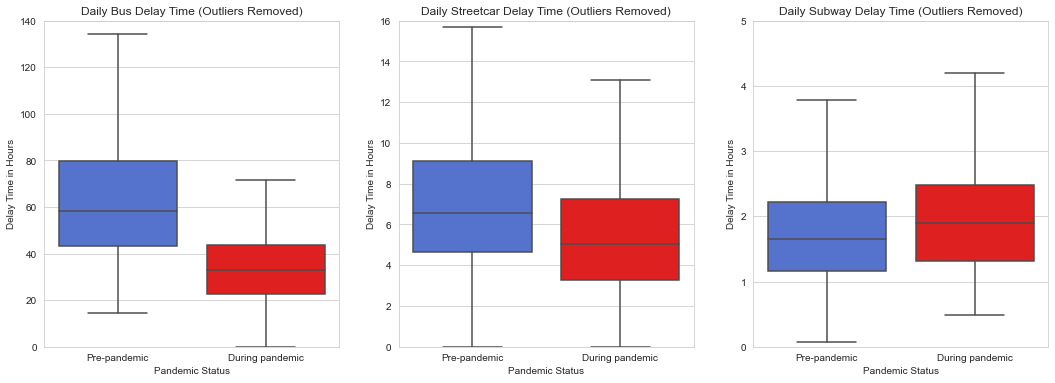

In [74]:
# y-axis range
ylims = {'bus':[0, 140], 'streetcar':[0, 16], 'subway':[0, 5]}

# initialize figure
plt.figure(figsize = (18, 6))
i = 1

# loop through transit types
for transit in transit_types:
    
    # make plot
    plt.subplot(1, 3, i)
    fig = sns.boxplot(data = tweets_per_day, x = 'pandemic', y = '{}Time'.format(transit), palette = {0:'royalblue', 1:'r'},
                      showfliers = False)
    fig.set(title = 'Daily {} Delay Time (Outliers Removed)'.format(transit.capitalize()), xlabel = 'Pandemic Status',
            ylabel = 'Delay Time in Hours', ylim = ylims[transit], xticklabels = ['Pre-pandemic', 'During pandemic'])
    
    # increment counter
    i += 1
    
# display plots
plt.show()

From the box plots above it does look as though daily bus and streetcar delay times were lower during the pandemic. As for daily subway delay times there is very little difference between days before the pandemic and days during the pandemic, and in fact delay times during the pandemic seem higher on average.

Let's apply Welch's t-tests to see whether the differences are statistically significant.

In [75]:
# loop through transit types
for transit in transit_types:

    # number of delays
    a = tweets_per_day[tweets_per_day['pandemic'] == 0]['{}Time'.format(transit)]
    b = tweets_per_day[tweets_per_day['pandemic'] == 1]['{}Time'.format(transit)]

    # apply test
    pval = stats.ttest_ind(a, b, equal_var = False).pvalue

    # print p-value
    print('\n')
    print("Welch's t-test p-value for {} delays: {:.2e}".format(transit, pval))



Welch's t-test p-value for bus delays: 1.25e-157


Welch's t-test p-value for streetcar delays: 7.77e-13


Welch's t-test p-value for subway delays: 2.43e-04


From the Welch's t-tests we find that all the differences are statistically significant, which is rather intriguing. Daily bus and streetcar delay times were higher on average before the pandemic. During the pandemic total daily bus delays averaged 35 hours and total daily streetcar delays averaged 6.0 hours but before the pandemic the daily bus and streetcar dailys were on average 67 hours and 7.6 hours per day, respectively.

Subway delay times actually increased during the pandemic, matching our previous finding of a slight increase in the number of subway delays during the pandemic. Before the pandemic total daily subway dela times were on average 1.9 hours per day but after the pandemic that number rose to 2.1 hours per day, a rather small increase.

We found there were fewer delays on weekends than on weekdays and fewer delays on Sundays than on Saturdays. Does the same conclusion hold for daily delay times?

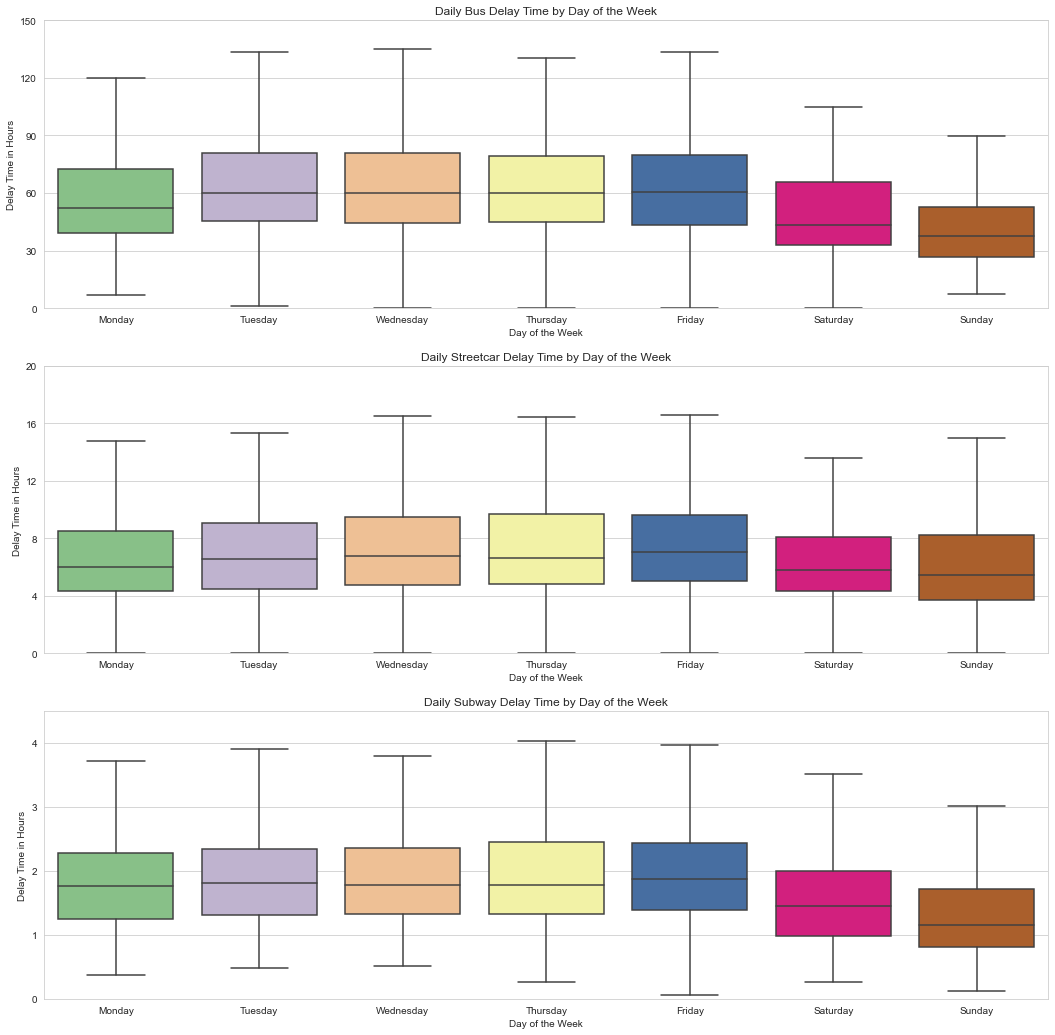

In [76]:
# y-axis range and tick marks
ylims = {'bus':[0, 150], 'streetcar':[0, 20], 'subway':[0, 4.5]}
yticks = {'bus':np.arange(0, 180, 30), 'streetcar':np.arange(0, 24, 4), 'subway':np.arange(0, 5, 1)}

# initialize figure
plt.figure(figsize = (18, 18))
i = 1

# loop through transit types
for transit in transit_types:

    # make plot
    plt.subplot(3, 1, i)
    fig = sns.boxplot(data = tweets_per_day, x = 'dayOfWeek', y = '{}Time'.format(transit), order = days, palette = 'Accent',
                      showfliers = False)
    fig.set(title = 'Daily {} Delay Time by Day of the Week'.format(transit.capitalize()), xlabel = 'Day of the Week',
            ylabel = 'Delay Time in Hours', ylim = ylims[transit], yticks = yticks[transit])
    
    # increment counter
    i += 1
    
# display plots
plt.show()

The same sort of behaviour does appear to hold.

In [77]:
# initialize dictionary of delay times
time_by_weekday = {'bus':dict(), 'streetcar':dict(), 'subway':dict()}

# loop through transit types
for transit in transit_types:
    
    # loop through days
    for day in days:
    
        # store delay times
        time_by_weekday[transit][day] = tweets_per_day[tweets_per_day['dayOfWeek'] == day]['{}Time'.format(transit)]
    
    # perform Kruskal-Wallis H-test
    pval = stats.kruskal(time_by_weekday[transit][days[0]], time_by_weekday[transit][days[1]],
                         time_by_weekday[transit][days[2]], time_by_weekday[transit][days[3]],
                         time_by_weekday[transit][days[4]], time_by_weekday[transit][days[5]],
                         time_by_weekday[transit][days[6]]).pvalue

    # print p-value
    print('\n')
    print('Kruskal-Wallis H-test p-value for {} delays: {:.2e}'.format(transit, pval))



Kruskal-Wallis H-test p-value for bus delays: 2.25e-52


Kruskal-Wallis H-test p-value for streetcar delays: 1.15e-09


Kruskal-Wallis H-test p-value for subway delays: 1.69e-44


Per the Kruskal-Wallis H-test there is a statistically significant difference between days of the week for total daily delay times in all transit types. To determine which pairs of days have statistically significant differences we use Welch's t-tests with a Holm-Bonferroni correction.

In [78]:
# loop through transit types
for transit in transit_types:

    # initialize list of day-pairs and p-values
    pairs = []
    pvals = []

    # loop through all pairs of days
    for i in days:
        for j in days:
            if i < j:
            
                # compute p-value
                pval = stats.ttest_ind(time_by_weekday[transit][i], time_by_weekday[transit][j], equal_var = False).pvalue
            
                # append day-pair and p-value
                pairs.append((i, j))
                pvals.append(pval)
            
    # initialize list to store pairs with statistically significant differences
    diff_pairs = []

    # apply Holm-Bonferroni correction
    hb = multipletests(pvals, method = 'holm')[0]

    # loop through day-pairs
    for i in range(len(pairs)):
    
        # check for pairs with statistically significant differences
        if hb[i]:
        
            # append to list of pairs
            diff_pairs.append(pairs[i])
        
    # print pairs with statistically significant differences
    print('\n')
    print('Pairs of days with statistically significant differences for the {} data:'.format(transit))
    for pair in diff_pairs:
        print(pair)



Pairs of days with statistically significant differences for the bus data:
('Monday', 'Tuesday')
('Monday', 'Wednesday')
('Monday', 'Sunday')
('Friday', 'Saturday')
('Friday', 'Sunday')
('Saturday', 'Tuesday')
('Saturday', 'Wednesday')
('Saturday', 'Thursday')
('Saturday', 'Sunday')
('Sunday', 'Tuesday')
('Sunday', 'Wednesday')
('Sunday', 'Thursday')


Pairs of days with statistically significant differences for the streetcar data:
('Friday', 'Monday')
('Friday', 'Saturday')
('Saturday', 'Tuesday')
('Saturday', 'Wednesday')
('Saturday', 'Thursday')


Pairs of days with statistically significant differences for the subway data:
('Monday', 'Saturday')
('Monday', 'Sunday')
('Friday', 'Saturday')
('Friday', 'Sunday')
('Saturday', 'Tuesday')
('Saturday', 'Wednesday')
('Saturday', 'Thursday')
('Saturday', 'Sunday')
('Sunday', 'Tuesday')
('Sunday', 'Wednesday')
('Sunday', 'Thursday')


Quite interestingly, we obtain the same trend only for the bus and subway data. For streetcars, we can only deduce that the total daily delay times on weekdays differs on average from the total daily delay times on Saturdays.

### Delays by Time of Day

Now let's have a look at the distribution of transit delays by the time of day.

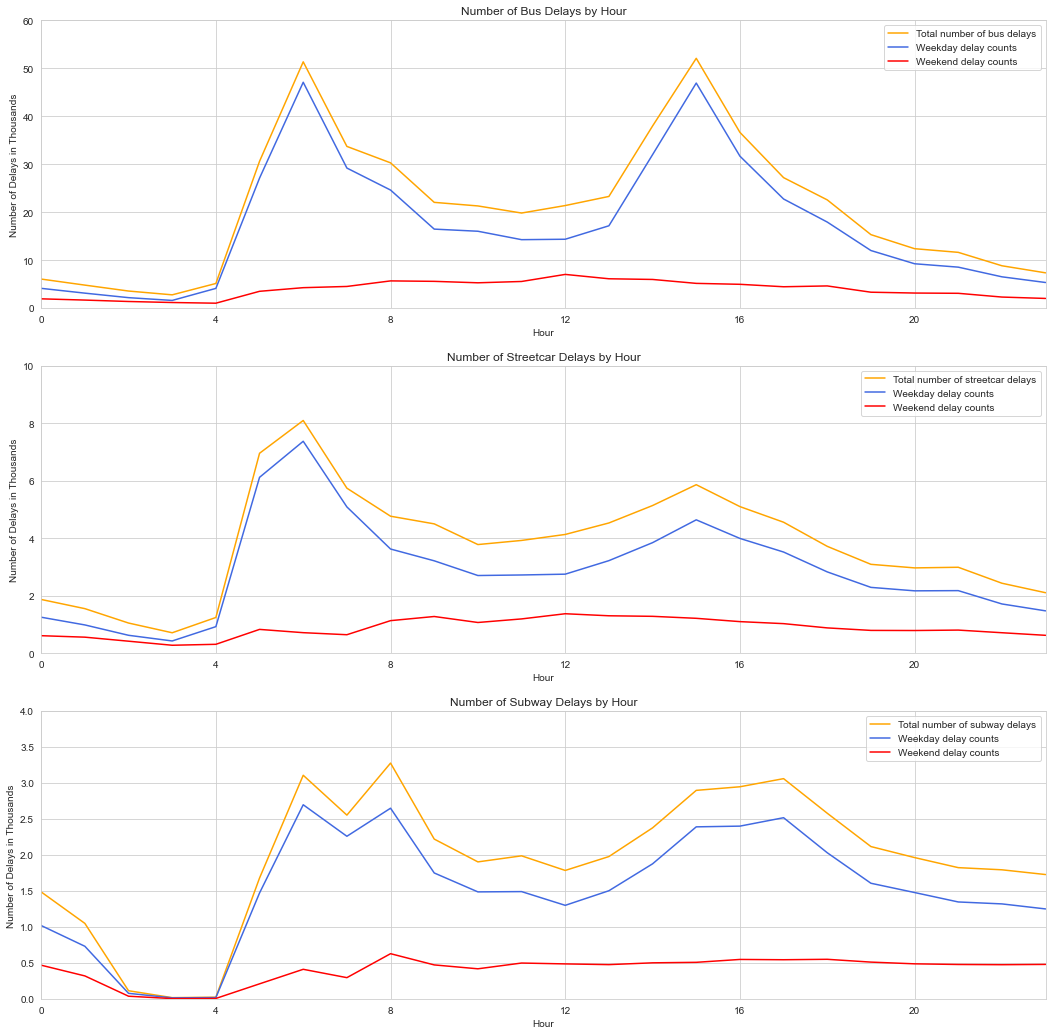

In [79]:
# y-axis range
ylims = {'bus':[0, 60], 'streetcar':[0, 10], 'subway':[0, 4]}

# initialize figure
plt.figure(figsize = (18, 18))
i = 1

# loop through transit types
for transit in transit_types:
    
    # separate data by weekday vs weekend
    weekday = delays[transit][~delays[transit]['Day'].isin(['Saturday', 'Sunday'])]
    weekend = delays[transit][delays[transit]['Day'].isin(['Saturday', 'Sunday'])]
    
    # get counts by hour
    delays_per_hour = delays[transit].groupby('Hour').count()['Report Date'].reset_index()
    delays_weekday = weekday.groupby('Hour').count()['Report Date'].reset_index()
    delays_weekend = weekend.groupby('Hour').count()['Report Date'].reset_index()

    # loop through dataframes
    hour_dfs = [delays_per_hour, delays_weekday, delays_weekend]
    for df in hour_dfs:
    
        # rename columns
        df.columns = ['hour', '{}Delays'.format(transit)]

        # record counts in thousands
        df['{}Delays'.format(transit)] /= 1000
    
    # make plot
    plt.subplot(3, 1, i)
    fig = sns.lineplot(data = delays_per_hour, x = 'hour', y = '{}Delays'.format(transit),
                       label = 'Total number of {} delays'.format(transit), color = 'orange')
    sns.lineplot(data = delays_weekday, x = 'hour', y = '{}Delays'.format(transit), label = 'Weekday delay counts',
                 color = 'royalblue')
    sns.lineplot(data = delays_weekend, x = 'hour', y = '{}Delays'.format(transit), label = 'Weekend delay counts', color = 'r')
    fig.set(title = 'Number of {} Delays by Hour'.format(transit.capitalize()), xlabel = 'Hour',
            ylabel = 'Number of Delays in Thousands', xlim = [0, 23], ylim = ylims[transit], xticks = np.arange(0, 24, 4))
    plt.legend()
    
    # increment counter
    i += 1

# display plots
plt.show()

These plots of the number of delays by hour strongly resembles the plots of number of tweets by hour in Part 1 but with slightly different peaks on weekdays. Indeed, we have peak times at around 6 am and 3 pm on weekdays as opposed to the previous Twitter peaks at 8 am and 5 pm. Weekends have a roughly consistent amount of delays throughout the day.

How do plots of total daily delay time by hour look?

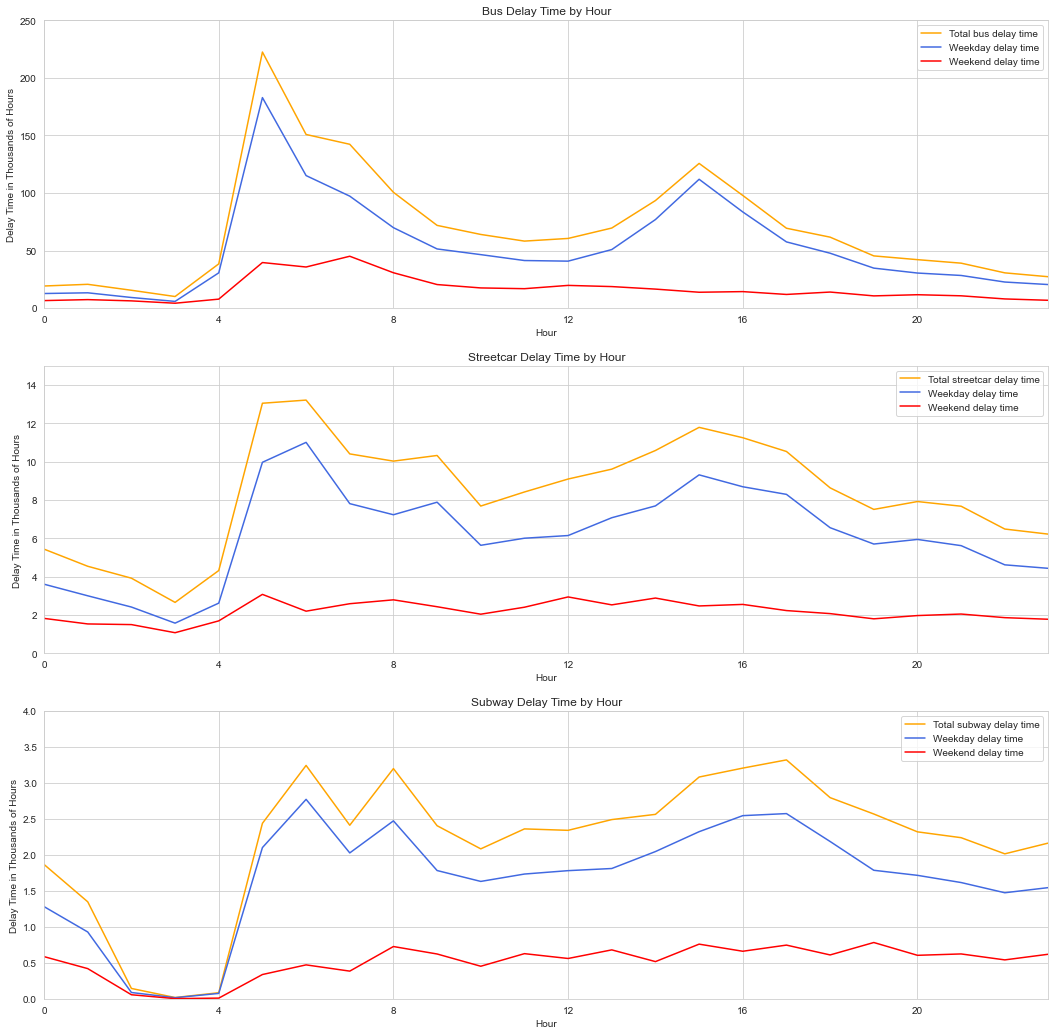

In [81]:
# y-axis range
ylims = {'bus':[0, 250], 'streetcar':[0, 15], 'subway':[0, 4]}

# initialize figure
plt.figure(figsize = (18, 18))
i = 1

# loop through transit types
for transit in transit_types:
    
    # separate data by weekday vs weekend
    weekday = delays[transit][~delays[transit]['Day'].isin(['Saturday', 'Sunday'])]
    weekend = delays[transit][delays[transit]['Day'].isin(['Saturday', 'Sunday'])]
    
    # get delay time by hour
    time_per_hour = delays[transit].groupby('Hour').sum()['Min Delay'].reset_index()
    time_weekday = weekday.groupby('Hour').sum()['Min Delay'].reset_index()
    time_weekend = weekend.groupby('Hour').sum()['Min Delay'].reset_index()

    # loop through dataframes
    time_dfs = [time_per_hour, time_weekday, time_weekend]
    for df in time_dfs:
    
        # rename columns
        df.columns = ['hour', '{}Time'.format(transit)]

        # record delay times in hours
        df['{}Time'.format(transit)] /= 6000
    
    # make plot
    plt.subplot(3, 1, i)
    fig = sns.lineplot(data = time_per_hour, x = 'hour', y = '{}Time'.format(transit),
                       label = 'Total {} delay time'.format(transit), color = 'orange')
    sns.lineplot(data = time_weekday, x = 'hour', y = '{}Time'.format(transit), label = 'Weekday delay time',
                 color = 'royalblue')
    sns.lineplot(data = time_weekend, x = 'hour', y = '{}Time'.format(transit), label = 'Weekend delay time', color = 'r')
    fig.set(title = '{} Delay Time by Hour'.format(transit.capitalize()), xlabel = 'Hour',
            ylabel = 'Delay Time in Thousands of Hours', xlim = [0, 23], ylim = ylims[transit], xticks = np.arange(0, 24, 4))
    plt.legend()
    
    # increment counter
    i += 1

# display plots
plt.show()

These plots appear quite similar to the plots of the number of delays by hour.

### Delay Times by Transit Type

Now let's compare delay times between transit types. We first get some summary statistics.

In [82]:
# loop through transit types
for transit in transit_types:
    
    # compute mean, median, and standard deviation
    mean = delays[transit]['Min Delay'].mean()
    median = delays[transit]['Min Delay'].median()
    std = delays[transit]['Min Delay'].std()
    
    # print mean, median, and standard deviation
    print('\n')
    print('Mean {} delay time: {} minutes'.format(transit, round(mean, 2)))
    print('Median {} delay time: {} minutes'.format(transit, round(median, 2)))
    print('{} delay time standard deviation: {} minutes'.format(transit.capitalize(), round(std, 2)))



Mean bus delay time: 19.8 minutes
Median bus delay time: 10.0 minutes
Bus delay time standard deviation: 69.37 minutes


Mean streetcar delay time: 13.28 minutes
Median streetcar delay time: 7.0 minutes
Streetcar delay time standard deviation: 32.19 minutes


Mean subway delay time: 6.81 minutes
Median subway delay time: 4.0 minutes
Subway delay time standard deviation: 14.5 minutes


We do not need any statistical tests to tell us that these distributions are different. On average, bus delays are quite lengthy with relatively high mean and median delay times. Streetcars are bit better and subway delays are best with the shortest mean and median delay times. However, all three have rather high standard deviations. This observation, coupled with the fact that the means are substantially larger than the medians, suggests that the delay times are quite positively skewed.

### Delays by Route

Now let's have a look at the **Route** feature. Which bus routes experience the most delays?

In [84]:
# total number of delays by route
most_delays = delays['bus'].groupby('Route').count()[['Report Date']].sort_values('Report Date', ascending = False)

# rename column
most_delays.columns = ['Number of Delays']

# bus routes with the most delays along with counts
most_delays.head(10) 

,Number of Delays
Route,
29,14438
52,13096
32,12845
36,11620
54,11134
53,10886
95,10454
60,10191
102,9412


The above bus routes are the 

* 29 Dufferin
* 52 Lawrence West
* 32 Eglinton West
* 36 Finch West
* 54 Lawrence East
* 53 Steeles East
* 95 York Mills
* 60 Steeles West
* 102 Markham Rd
* 35 Jane

Although there are [more than 140 bus routes](https://www.ttc.ca/Routes/General_Information/General_Information.jsp), the ten routes above experience 22% of all bus delays.

Now let's have a look at the most delayed bus routes by total delay time.

In [85]:
# total delay time by route
most_delays = delays['bus'].groupby('Route').sum()[['Min Delay']].sort_values('Min Delay', ascending = False)

# rename column
most_delays.columns = ['Total Delay Time in Hours']

# convert to hours
most_delays /= 60

# round values
most_delays = most_delays.apply(lambda x: round(x, 2))

# bus routes with the most total delay time along with total delay times
most_delays.head(10)

,Total Delay Time in Hours
Route,
52,3953.32
121,3340.62
32,3292.53
29,3213.20
102,3120.33
54,2904.98
96,2698.52
41,2642.65
87,2550.12


This list is largely the same except with the addition of a few new bus routes:

* 121 Fort-York Esplanade
* 96 Wilson
* 41 Keele
* 87 Cosburn

The ten routes above account for about 18% of all delay times.

How about the streetcar routes? Which routes experience the most delays?

In [59]:
# total number of delays by route
most_delays = delays['streetcar'].groupby('Route').count()[['Report Date']].sort_values('Report Date', ascending = False)

# rename column
most_delays.columns = ['Number of Delays']

# streetcar routes with the most delays along with counts
most_delays.head(3)

,Number of Delays
Route,
501,22630
504,16800
506,12838


The 501 Queen, the 504 King, and the 506 Carlton alone experience over half of all streetcar delays. The same conclusion holds when we consider total delay time instead.

In [86]:
# total delay time by route
most_delays = delays['streetcar'].groupby('Route').sum()[['Min Delay']].sort_values('Min Delay', ascending = False)

# rename column
most_delays.columns = ['Total Delay Time in Hours']

# convert to hours
most_delays /= 60

# round values
most_delays = most_delays.apply(lambda x: round(x, 2))

# bus routes with the most total delay time along total delay times
most_delays.head(3)

,Total Delay Time in Hours
Route,
501,5052.13
504,3560.35
506,2850.88


How about the subway delays by line?

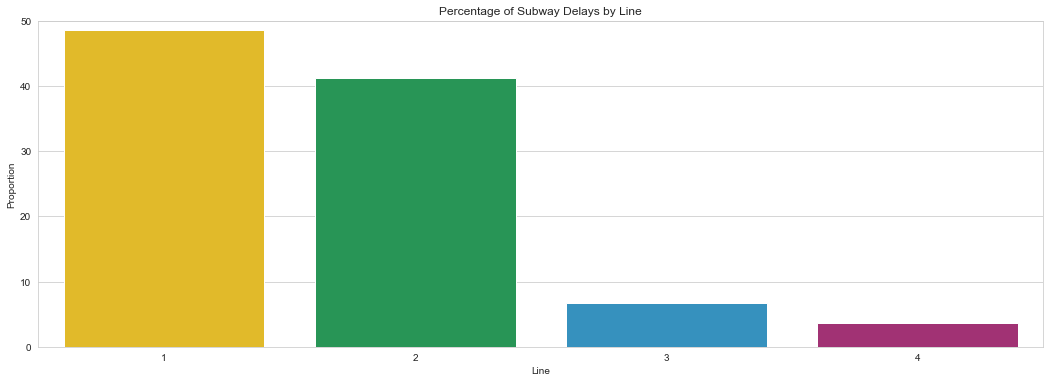

In [90]:
# total number of delays by line
most_delays = delays['subway'].groupby('Route').count()[['Report Date']].sort_values('Report Date', ascending = False)

# rename column
most_delays.columns = ['Count']

# line colours
line_colours = {1:'#FFCB0C', 2:'#16A753', 3:'#1F99D5', 4:'#B32078'}

# make plot
plt.figure(figsize = (18, 6))
fig = sns.barplot(x = most_delays.index, y = 100 * most_delays['Count'] / delays['subway'].shape[0], palette = line_colours)
fig.set(title = 'Percentage of Subway Delays by Line', xlabel = 'Line', ylabel = 'Proportion', ylim = [0, 50])
plt.show()

Lines 1 and 2 easily experince the most delays, accouting for roughly 49% and 41%, respectively, of all subway delays. When considering total delay time we get similar results.

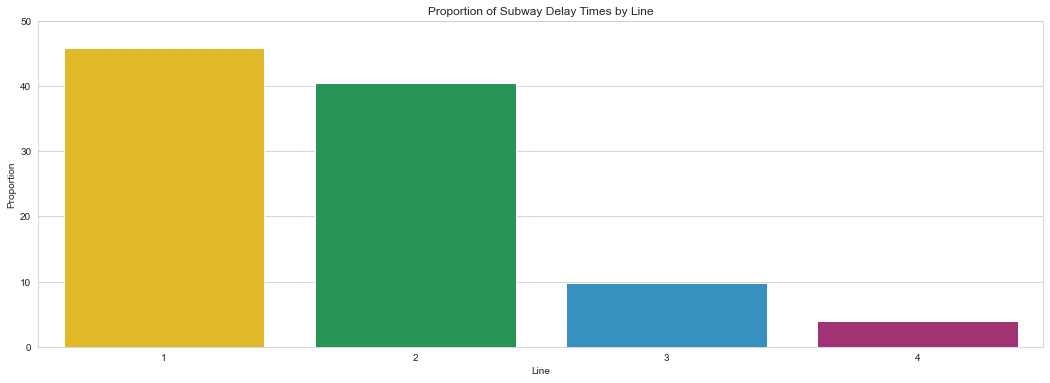

In [92]:
# total delay time
tot_delay = delays['subway']['Min Delay'].sum()

# total number of delays by route
most_delays = delays['subway'].groupby('Route').sum()[['Min Delay']].sort_values('Min Delay', ascending = False)

# rename column
most_delays.columns = ['Delay Time']

# make plot
plt.figure(figsize = (18, 6))
fig = sns.barplot(x = most_delays.index, y = 100 * most_delays['Delay Time'] / tot_delay, palette = line_colours)
fig.set(title = 'Proportion of Subway Delay Times by Line', xlabel = 'Line', ylabel = 'Proportion', ylim = [0, 50])
plt.show()

Perhaps this comparison is a bit unfair since Lines 1 and 2 have far more stations than Lines 3 and 4. Indeed, Lines 1, 2, 3, and 4 have 38, 31, 6, and 5 stations, respectively. If we normalize by the number of stations then do we get a different story?

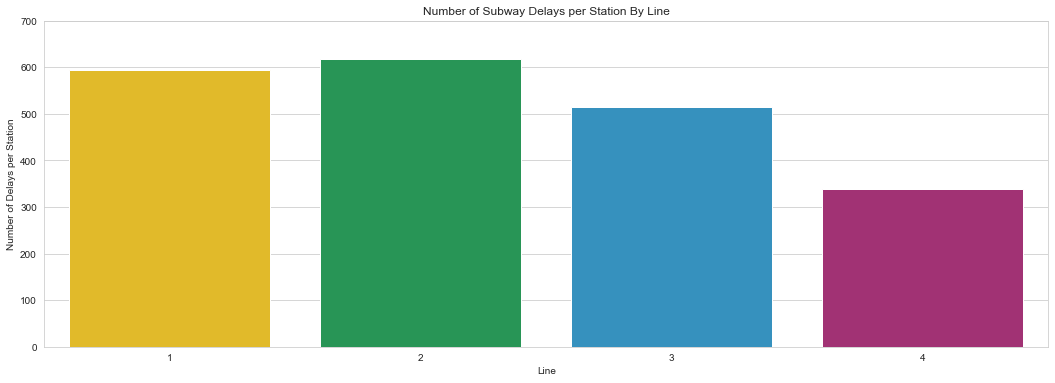

In [96]:
# total number of delays by route
most_delays = delays['subway'].groupby('Route').count()[['Report Date']].sort_values('Report Date', ascending = False)

# number of stations per line
num_stat = [38, 31, 6, 5]

# rename column
most_delays.columns = ['Count']

# normalize counts
most_delays['Count'] = np.divide(most_delays['Count'], num_stat)

# make plot
plt.figure(figsize = (18, 6))
fig = sns.barplot(x = most_delays.index, y = most_delays['Count'], palette = line_colours)
fig.set(title = 'Number of Subway Delays per Station By Line', xlabel = 'Line', ylabel = 'Number of Delays per Station',
        ylim = [0, 700])
plt.show()

Normalizing by the number of stations shows that Line 2 actually has the most delays per station, although Line 1 is not far behind. How about for the total delay time?

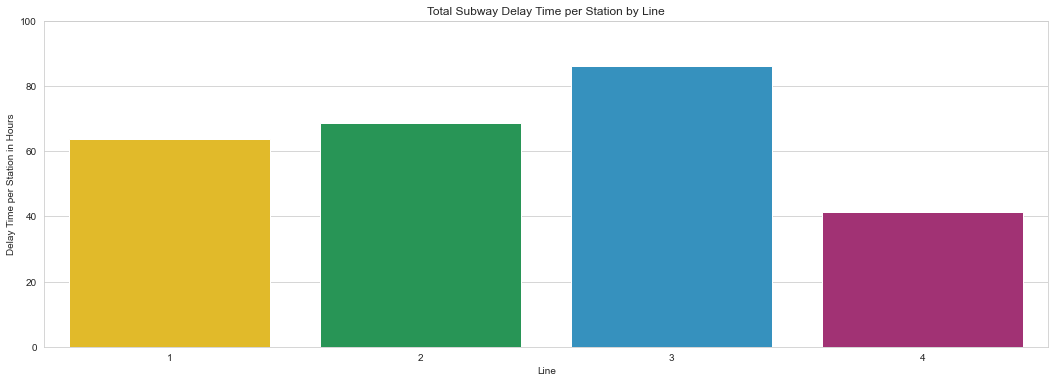

In [97]:
# total number of delays by route
most_delays = delays['subway'].groupby('Route').sum()[['Min Delay']].sort_values('Min Delay', ascending = False)

# rename column
most_delays.columns = ['Delay Time']

# normalize times in hours
most_delays['Delay Time'] = np.divide(most_delays['Delay Time'], num_stat) / 60

# make plot
plt.figure(figsize = (18, 6))
fig = sns.barplot(x = most_delays.index, y = most_delays['Delay Time'], palette = line_colours)
fig.set(title = 'Total Subway Delay Time per Station by Line', xlabel = 'Line', ylabel = 'Delay Time per Station in Hours',
        ylim = [0, 100])
plt.show()

When normalizing by the number of stations we find that Line 3 actually has the highest per station delay time! This is likely due to the fact that by 2021, the trains operating on Line 3 were [ten years past their life expectancy](https://www.ttc.ca/About_the_TTC/Projects/Future_of_SRT/srt.jsp), making them difficult to keep in serviceable condition. In fact, due to their age the TTC will decommission Line 3 in 2023, replacing the line with a bus route until the Scarborough Subway Extension opens in 2030.

### Delays by Location

Where are the delay hotspots in Toronto? Let's have a look at the **Location** feature in each dataset.

In [98]:
# total number of delays by location
loc_delays = delays['bus'].groupby('Location').count()[['Report Date']].sort_values('Report Date', ascending = False)

# rename column
loc_delays.columns = ['Number of Delays']

# locations with the most bus delays along with counts
loc_delays.head(10)

,Number of Delays
Location,
KENNEDY STATION,12123
FINCH STATION,11955
WARDEN STATION,9614
ENTIRE ROUTE,9248
EGLINTON STATION,8582
KIPLING STATION,8332
WILSON STATION,8050
DOWNSVIEW STATION,7848
STC,5698


Eight of the ten most common locations to experience a bus delay are subway stations with Kennedy Station at the top of the list. The two which are not subway stations are along the entire bus route, which is the fourth-most common, as well as the Scarborough Town Centre sitting at number nine. It should be noted however that the Scarborough Town Centre is adjacent to a subway station.

Subway stations tend to be bus hubs and so it makes sense that they are the sites of most bus delays. For example, 12 bus routes stop at Kennedy Station and ten stop at Finch Station. Moreover, subway stations are often the first and last stops of a bus route. When we consider the most common locations for streetcar and subway delays we will find those tend to occur at terminal stations too.

What if we consider total delay time instead?

In [99]:
# total delay time by location
most_delays = delays['bus'].groupby('Location').sum()[['Min Delay']].sort_values('Min Delay', ascending = False)

# rename column
most_delays.columns = ['Total Delay Time in Hours']

# convert to hours
most_delays /= 60

# round values
most_delays = most_delays.apply(lambda x: round(x, 2))

# bus routes with the most total delay time along with total delay time
most_delays.head(10)

,Total Delay Time in Hours
Location,
MAIN STATION,3808.03
MSTN,3338.50
ENTIRE ROUTE,2657.78
KENNEDY STATION,2143.22
WARDEN STATION,2100.53
FINCH STATION,1964.10
EGLINTON STATION,1683.92
KIPLING STATION,1496.92
WILSON STATION,1326.25


This time nine of the top ten locations are subway stations. However a station is repeated in our top ten as both "MAIN STATION" and "MSTN" refer to Main Street Station. Consequently Main Street Station has by far the most delay time, equaling over 300 full days in bus delays.

Let's repeat our analysis but with streetcar delays.

In [100]:
# total number of delays by location
loc_delays = delays['streetcar'].groupby('Location').count()[['Report Date']].sort_values('Report Date', ascending = False)

# rename column
loc_delays.columns = ['Number of Delays']

# locations with the most streetcar delays along with counts
loc_delays.head(10)

,Number of Delays
Location,
BROADVIEW STATION,1913
DUNDAS WEST STATION,1911
RUSSELL YARD,1530
QUEEN AND CONNAUGHT,1196
QUEEN AND RONCESVALLES,1108
CNE LOOP,1016
BATHURST STATION,1014
LESLIE BARNS,1007
RONCESVALLES AND QUEEN,949


Subway stations are again among the most delayed locations but there are quite a few other locations among the top ten.

As previously mentioned, Russell Yard is where the TTC stores some of its streetcars. It appears twice in out list of most delayed locations, once as "RUSSELL YARD" and again as "QUEEN AND CONNAUGHT". Leslie Barns is another streetcar storage centre and appears as the location with the eighth most streetcar delays.

Both "QUEEN AND RONCESVALLES" and "RONCESVALLES AND QUEEN" clearly refer to the same intersection. This intersection is the site of a major [infrastructure upgrade](https://www.toronto.ca/community-people/get-involved/public-consultations/infrastructure-projects/king-queen-queensway-roncesvalles-construction/) and so delays here are not unexpected.

Also on our list is the CNE loop by Exhibition Place and Humber Loop. Both are terminal stops for many of the routes they serve.

Now let's consider the locations with the highest total streetcar delay times.

In [101]:
# total delay time by location
most_delays = delays['streetcar'].groupby('Location').sum()[['Min Delay']].sort_values('Min Delay', ascending = False)

# rename column
most_delays.columns = ['Total Delay Time in Hours']

# convert to hours
most_delays /= 60

# round values
most_delays = most_delays.apply(lambda x: round(x, 2))

# streetcar routes with the most total delay time along with total delay time
most_delays.head(10)

,Total Delay Time in Hours
Location,
DUNDAS WEST STATION,276.23
BROADVIEW STATION,239.38
RUSSELL YARD,170.85
HUMBER LOOP,169.65
CNE LOOP,166.28
LESLIE BARNS,154.63
QUEEN AND CONNAUGHT,151.45
KING AND SPADINA,150.32
RONCY YARD,127.62


Roncy Yard, or Roncesvalles Carhouse, is the third of the TTC's streetcar storage sites. It is rather interesting to note that a substantial portion of the streetcar delays occur at carhouses.

Now let's turn our attention to the locations with the most subway delays.

In [102]:
# total number of delays by location
loc_delays = delays['subway'].groupby('Location').count()[['Report Date']].sort_values('Report Date', ascending = False)

# rename column
loc_delays.columns = ['Number of Delays']

# locations with the most subway delays along with counts
loc_delays.head(10)

,Number of Delays
Location,
KENNEDY BD STATION,2106
FINCH STATION,1836
KIPLING STATION,1734
SHEPPARD WEST STATION,1671
EGLINTON STATION,1589
WILSON STATION,1517
VAUGHAN MC STATION,1492
MCCOWAN STATION,1205
BLOOR STATION,1190


Most subway delays seem to occur at terminal stations. Let's check this observation by looking at the two most common delay locations by subway line.

In [104]:
# loop through subway lines
for line in [1, 2, 3, 4]:
    
    # restrict to delays on given line
    delays_line = delays['subway'][delays['subway']['Route'] == line]
    
    # most common delay locations
    comm_locs = 100 * delays_line['Location'].value_counts() / delays_line.shape[0]
    
    # print percentages for the top two locations
    print('\n')
    for i in range(2):
        print('{}% of Line {} delays occur at {}'.format(round(comm_locs[i], 1), line, comm_locs.index[i]))



8.1% of Line 1 delays occur at FINCH STATION
7.4% of Line 1 delays occur at SHEPPARD WEST STATION


11.0% of Line 2 delays occur at KENNEDY BD STATION
9.1% of Line 2 delays occur at KIPLING STATION


39.1% of Line 3 delays occur at MCCOWAN STATION
23.2% of Line 3 delays occur at KENNEDY SRT STATION


27.1% of Line 4 delays occur at YONGE SHP STATION
26.3% of Line 4 delays occur at DON MILLS STATION


With the exception of Line 1 we do indeed observe that the two most common delay locations for each subway line occur at the terminal stations. The situation is slightly different however for Line 1. Sheppard West Station is not currently a terminal station for Line 1 but it was a terminus before the Line 1 extension was completed in December 2017. Thus for over half of our dataset Sheppard West Station was a terminal station.

If we look at the third most common delay location for Line 1 would we find the new terminus, Vaughan Metropolitan Centre Station? On the one hand this is a terminal station and we observed that many delays occur at such stations. On the other hand, this station only existed for half the time frame of our dataset, meaning it has less opportunity to accrue delays. It turns out that Vaughan Metropolitan Centre Station is not the third most delayed location but rather the fifth most common.

In [105]:
# restrict to delays on Line 1
delays_line = delays['subway'][delays['subway']['Route'] == 1]
    
# most common delay locations
comm_locs = 100 * delays_line['Location'].value_counts() / delays_line.shape[0]
    
# print percentages for the top five locations
for i in range(5):
    print('{}% of Line 1 delays occur at {}'.format(round(comm_locs[i], 1), comm_locs.index[i]))

8.1% of Line 1 delays occur at FINCH STATION
7.4% of Line 1 delays occur at SHEPPARD WEST STATION
7.0% of Line 1 delays occur at EGLINTON STATION
6.7% of Line 1 delays occur at WILSON STATION
6.6% of Line 1 delays occur at VAUGHAN MC STATION


The situation when we consider total delay time is similar.

In [106]:
# loop through subway lines
for line in [1, 2, 3, 4]:
    
    # restrict to delays on given line
    delays_line = delays['subway'][delays['subway']['Route'] == line]
    
    # total delay time
    tot_delay = delays_line['Min Delay'].sum()
    
    # group by location
    locs = 100 * delays_line.groupby('Location').sum()[['Min Delay']].sort_values('Min Delay', ascending = False) / tot_delay
    
    # print percentages for the top two locations
    print('\n')
    for i in range(2):
        print('{}% of the total Line {} delay times occur at {}'.format(round(locs.iloc[i, 0], 1), line, locs.index[i]))



7.0% of the total Line 1 delay times occur at SHEPPARD WEST STATION
6.3% of the total Line 1 delay times occur at EGLINTON STATION


8.5% of the total Line 2 delay times occur at KENNEDY BD STATION
6.4% of the total Line 2 delay times occur at KIPLING STATION


31.6% of the total Line 3 delay times occur at MCCOWAN STATION
24.4% of the total Line 3 delay times occur at KENNEDY SRT STATION


27.2% of the total Line 4 delay times occur at DON MILLS STATION
24.9% of the total Line 4 delay times occur at YONGE SHP STATION


Once again we find the two terminus stations for each line at the top of the lists except for Line 1. Curiously, this time Sheppard West Station is not at number two for Line 1. As before we need to consider the top five stations before Vaughan Metropolitan Centre Station appears.

In [107]:
# restrict to delays on Line 1
delays_line = delays['subway'][delays['subway']['Route'] == 1]
    
# total delay time
tot_delay = delays_line['Min Delay'].sum()
    
# group by location
locs = 100 * delays_line.groupby('Location').sum()[['Min Delay']].sort_values('Min Delay', ascending = False) / tot_delay
    
# print percentages for the top five locations
for i in range(5):
    print('{}% of Line 1 delays occur at {}'.format(round(comm_locs[i], 1), comm_locs.index[i]))

8.1% of Line 1 delays occur at FINCH STATION
7.4% of Line 1 delays occur at SHEPPARD WEST STATION
7.0% of Line 1 delays occur at EGLINTON STATION
6.7% of Line 1 delays occur at WILSON STATION
6.6% of Line 1 delays occur at VAUGHAN MC STATION


### Reasons for Delays

The last facet we will explore before considering the delay data and Twitter data in tandem is the reason behind delays. What are the most common causes of bus delays?

In [108]:
# total number of delays by incident
inc_delays = delays['bus'].groupby('Incident').count()[['Report Date']].sort_values('Report Date', ascending = False)

# rename column
inc_delays.columns = ['Percentage']

# convert to percentage
inc_delays *= 100 / delays['bus'].shape[0]

# round values
inc_delays = inc_delays.apply(lambda x: round(x, 2))

# incident types with the most bus delays along with percentages
inc_delays.head()

,Percentage
Incident,
MECHANICAL,36.63
UTILIZED OFF ROUTE,15.20
GENERAL DELAY,13.21
LATE LEAVING GARAGE,12.71
INVESTIGATION,9.21


Mechanical issues seem to be relatively common, being by far the most frequent reason behind a bus delay. How about the main contributors to total bus delay time?

In [109]:
# total delay time
tot_delay = delays['bus']['Min Delay'].sum()

# total delay time by incident
inc_delays = delays['bus'].groupby('Incident').sum()[['Min Delay']].sort_values('Min Delay', ascending = False)

# rename column
inc_delays.columns = ['Percentage']

# convert to percentage
inc_delays *= 100 / tot_delay

# round values
inc_delays = inc_delays.apply(lambda x: round(x, 2))

# incident types with the most total delay time along with total delay time
inc_delays.head()

,Percentage
Incident,
DIVERSION,41.08
MECHANICAL,21.51
GENERAL DELAY,12.32
LATE LEAVING GARAGE,6.73
UTILIZED OFF ROUTE,6.55


Despite making up about 37% of all delays we find that mechanical issues only constitute roughly 22% of bus delay time. By contrast, route diversions are behind 5.5% of delays but account for over 40% of bus delay time. This suggests that delays due to route diversions tend to be much longer than delays caused by mechanical troubles.

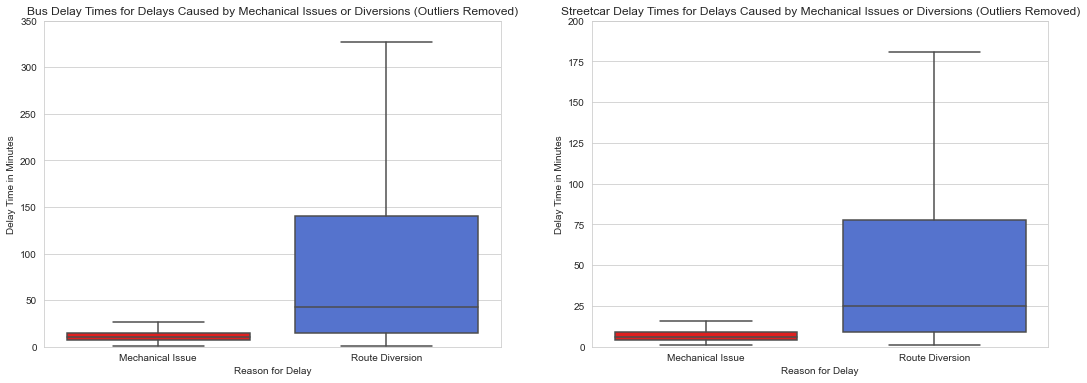

In [113]:
# y-axis range
ylims = {'bus':[0, 350], 'streetcar':[0, 200]}

# initialize figure
plt.figure(figsize = (18, 6))
i = 1

# loop through transit types
for transit in transit_types:
    
    # restrict attention to buses and streetcars
    if transit != 'subway':
    
        # feature recording whether incident is a mechanical issue
        delays[transit]['Mechanical'] = delays[transit]['Incident'].apply(lambda x: 1 * (x == 'MECHANICAL'))
        
        # only consider delays due to mechanical issues or diversions
        mech_or_div = delays[transit][delays[transit]['Incident'].isin(['MECHANICAL', 'DIVERSION'])]
    
        # make plot
        plt.subplot(1, 2, i)
        fig = sns.boxplot(data = mech_or_div, x = 'Mechanical', y = 'Min Delay', showfliers = False, order = [1, 0],
                          palette = {0:'royalblue', 1:'r'})
        fig.set(title = '{} Delay Times for Delays Caused by Mechanical Issues or Diversions (Outliers Removed)'.format(transit.capitalize()),
                xlabel = 'Reason for Delay', ylabel = 'Delay Time in Minutes', ylim = ylims[transit],
                xticklabels = ['Mechanical Issue', 'Route Diversion'])

        # increment counter
        i += 1
    
# display plots
plt.show()

It is quite apparent that route diversions have a tendency to cause much longer delays than mechanical issues in both buses and streetcars. Indeed, mechanical issues lead to delays with median lengths of 10 minutes for buses and 6 minutes for streetcars whereas route diversions cause delays with median times of 43 minutes for buses and 25 minutes for streetcars. No Welch's t-tests are needed here to conclude that these groups differ.

Now let's take a look at the subway **Incident** data, starting with the most common incidents.

In [121]:
# total number of delays by incident
inc_delays = delays['subway'].groupby('Incident').count()[['Report Date']].sort_values('Report Date', ascending = False)

# rename column
inc_delays.columns = ['Percentage']

# convert to percentage
inc_delays *= 100 / delays['subway'].shape[0]

# round values
inc_delays = inc_delays.apply(lambda x: round(x, 2))

# incident types with the most bus delays along with percentages
inc_delays.head()

,Percentage
Incident,
DISORDERLY PATRON,9.52
INJURED/ILL CUSTOMER ON TRAIN - MEDICAL AID REFUSED,6.31
INJURED/ILL CUSTOMER ON TRAIN - TRANSPORTED,5.09
UNKNOWN,5.04
PAA - NO TROUBLE FOUND,4.41


There is an intriguing contrast between the reasons behind bus delays and the cuases of subway delays. Generally speaking, bus delays were not caused by TTC customers. Patrons do not cause mechanical issues nor do they cause drivers to leave the garage late. Traffic conditions force route diversions, not the customers. But we see that the main reasons behind subway delays are related to customers. Disorderly patrons are the single most common reason behind subway delays, accounting for nearly a tenth of all subway delays. Injured and/or ill customers cause 11.4% of subway delays. Misuse of the Passenger Assistance Alarm, or PAA, is behind 4.4% of subway delays, making it the fifth most common reason cause for subway delays. No wonder the TTC constantly reminds its patrons that emergency alarms are to be used during emergencies only!

The above are the most common reasons for subway delays but do they also account for the most subway delay times?

In [115]:
# total delay time
tot_delay = delays['subway']['Min Delay'].sum()

# total delay time by incident
inc_delays = delays['subway'].groupby('Incident').sum()[['Min Delay']].sort_values('Min Delay', ascending = False)

# rename column
inc_delays.columns = ['Percentage']

# convert to percentage
inc_delays *= 100 / tot_delay

# round values
inc_delays = inc_delays.apply(lambda x: round(x, 2))

# incident types with the most total delay time along with total delay time
inc_delays.head()

,Percentage
Incident,
DISORDERLY PATRON,7.97
INJURED/ILL CUSTOMER ON TRAIN - TRANSPORTED,6.82
PRIORITY ONE - TRAIN IN CONTACT WITH PERSON,5.61
FIRE/SMOKE PLAN B,5.08
INJURED/ILL CUSTOMER ON TRAIN - MEDICAL AID REFUSED,4.92


A few reasons return when considering total delay times instead. Disorderly patrons still sit at the top of the list and injured/ill customers are again major contributors.

Priority one alerts, which indicate a collision between a train and an individual, are the third-largest contributor to subway delay times. While thankfully rare and making up less than 0.5% of all subway delays, these terrible and traumatic events cause the subway system to grind to a halt for quite some time. Fires also appear to be a major source of lengthy delays.

## Relationships With the Twitter Data

We now explore whether there is a link between transit delays and our tweets. Do days with more bus delays also happen to have more tweets? Do they have more negative mean sentiment scores? Let's start with a heatmap of relevant correlation coefficients.

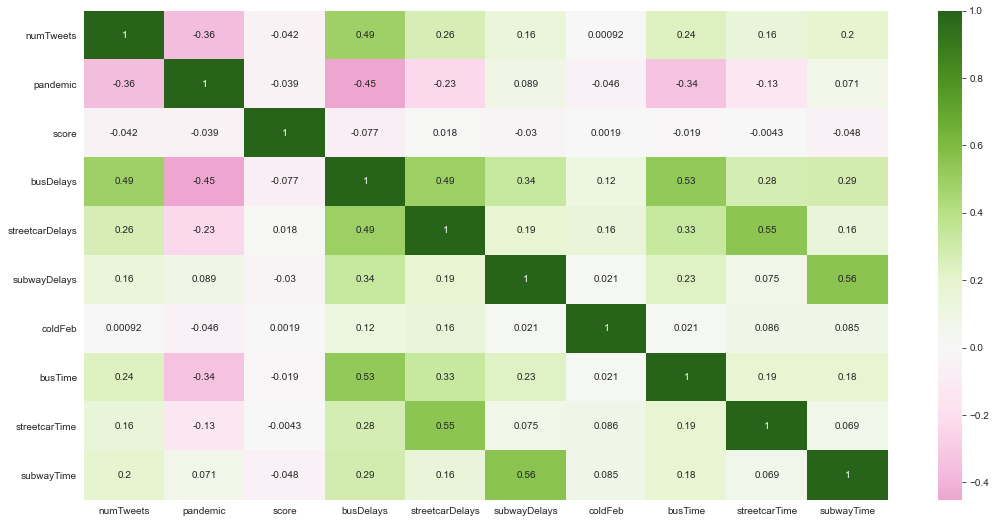

In [123]:
# make heatmap
plt.figure(figsize = (18, 9))
fig = sns.heatmap(data = tweets_per_day.corr(), cmap = 'PiYG', center = 0, annot = True)
plt.show()

The number of tweets per day weakly correlates with the number of bus delays per day but not with much else. The mean daily sentiment score however does not correlate well with any delay data. I find this rather surprising. The motivation behind this project was to ascertain the effect of transit delays and closures on Twitter sentiment and I thought there would certainly be some sort of effect. That appears to not be the case however and we have over the course of this project found very little relating to sentiment.

Although we were unable to find many factors related to sentiment, not all is lost. In Parts 1 and 2 we found a few features that impacted the number of tweets and here we find another. Unlike the number of streetcar or subway delays, the number of bus delays in a given day does seem to impact the number of tweets per day.

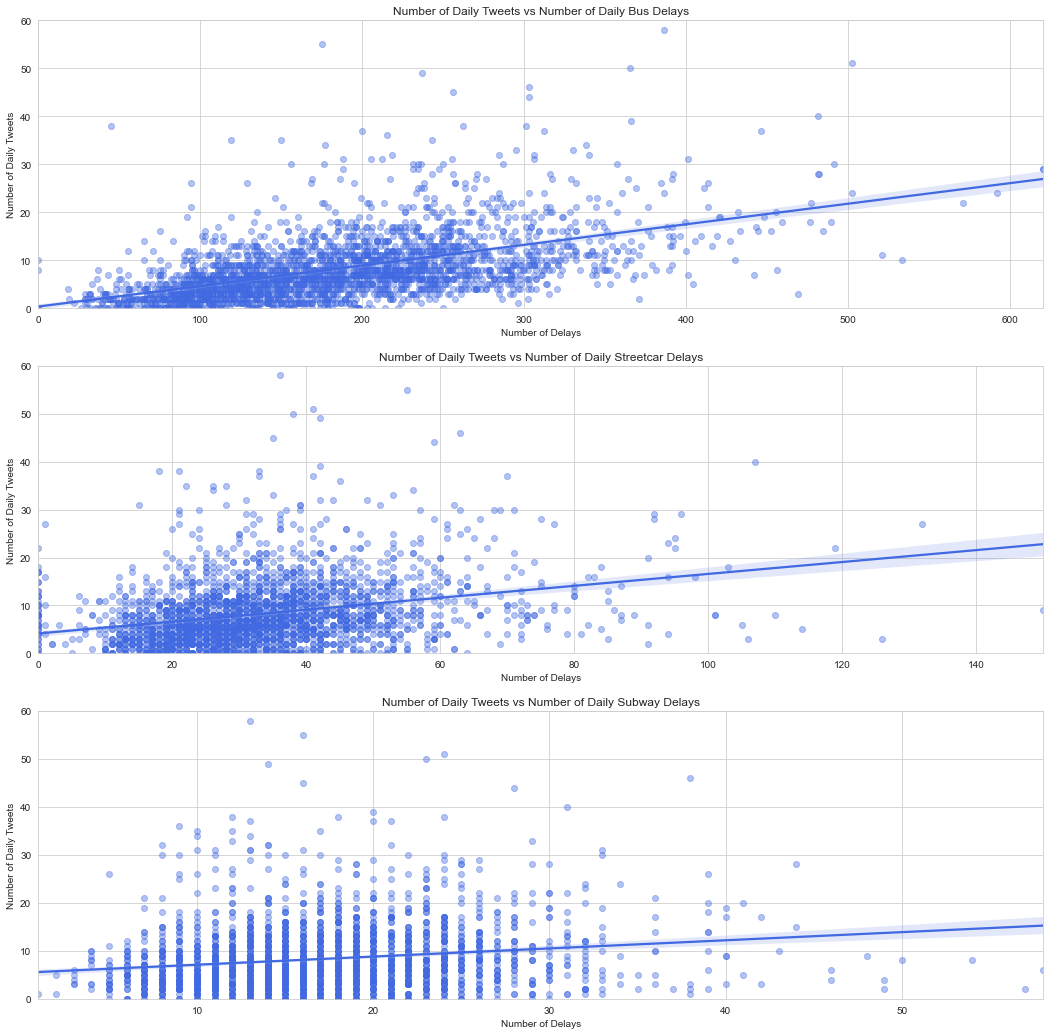

In [125]:
# initialize figure
plt.figure(figsize = (18, 18))
i = 1

# loop through transit types
for transit in transit_types:
    
    # make plot
    plt.subplot(3, 1, i)
    fig = sns.regplot(data = tweets_per_day, x = '{}Delays'.format(transit), y = 'numTweets', color = 'royalblue',
                      scatter_kws = {'alpha':alpha})
    fig.set(title = 'Number of Daily Tweets vs Number of Daily {} Delays'.format(transit.capitalize()),
            xlabel = 'Number of Delays', ylabel = 'Number of Daily Tweets', ylim = [0, 60])
    
    # increment plot
    i += 1
    
# display plots
plt.show()

While not strong, we do note a correlation between the number of daily tweets and the number of bus delays but not so much for the number of streetcar delays nor subway delays. This is quite interesting as we found through a word cloud in Part 1 that of the three transit types, the subway and streetcar systems were mentioned far more often than buses. Despite this, buses are more impactful than streetcars or subways in determining the number of tweets in a given day.

These correlations worsen when we consider the total transit delay time instead.

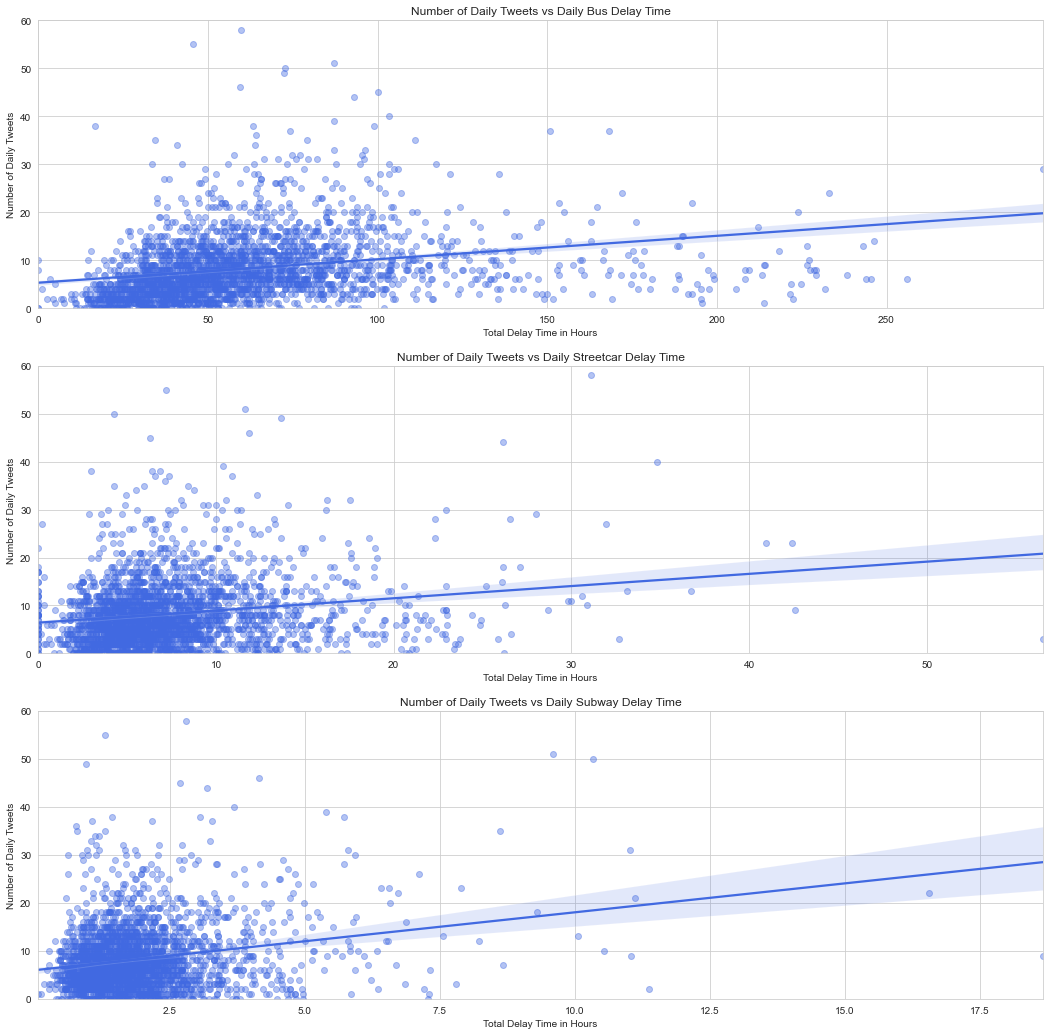

In [126]:
# initialize figure
plt.figure(figsize = (18, 18))
i = 1

# loop through transit types
for transit in transit_types:
    
    # make plot
    plt.subplot(3, 1, i)
    fig = sns.regplot(data = tweets_per_day, x = '{}Time'.format(transit), y = 'numTweets', color = 'royalblue',
                      scatter_kws = {'alpha':alpha})
    fig.set(title = 'Number of Daily Tweets vs Daily {} Delay Time'.format(transit.capitalize()),
            xlabel = 'Total Delay Time in Hours', ylabel = 'Number of Daily Tweets', ylim = [0, 60])
    
    # increment plot
    i += 1
    
# display plots
plt.show()

Thus it appears that the quantity of tweets is more closely related to the quantity of delays and not how long the delays last.

## Conclusion

With this we conclude our analysis of #TTC tweets and their relationship with subway closures and transit delays. In this final component of the project we learned quite a bit about transit delays. While not all that surprising we noted that inclement weather played a role in transit delays with days of heavy snowfall or extremely cold temperatures generally having more bus and streetcar delays.

Reduced ridership during the COVID-19 pandemic is a likely factor in why there were more bus and streetcar delays before the pandemic than during the pandemic. By contrast, the number of subway delays stays roughly constant and there is in fact a slight *increase* in delays during the pandemic.

Much like the Twitter data, there is a stark difference in the number of delays between weekdays and weekends. Weekdays tended to have the most delays, followed by Saturdays, with Sundays having relatively few delays. Also similar to the Twitter data is the distribution of delays by time of day. We observed that on weekdays there tended to be two peak times for delays. These peaks occur at around 6 am and 3 pm which is slightly earlier than the two peaks of 8 am and 5 pm found in weekday Twitter usage. Also similar to the Twitter data is the fact that delays on weekends tend to hover around a constant value throughout the day. These trends were also observed when considering daily total delay time.

We also found that nearly half of all subway delays occur on Line 1 and the same is true of total delay time. However, once we normalize by the number of stations in each line we find that Line 3 actually has the most total delay time per station! This is actually not too surprising given that the trains operating on Line 3 have aged beyond their anticipated life expectancy, leading to the decision that Line 3 will be decommisioned in 2023.

For buses and subways we noted that delays tended to occur at terminal stations. The sole exception was Line 1 but this can be explained by the fact that one of the current terminal stations, Vaughan Metropolitan Centre Station, existed for approximately 3.5 years of our 7.5 year dataset. The situation was slightly different for streetcars however as we found that a significant portion of streetcar delays actually occur at the three carhouses the TTC uses to store and dispatch its fleet of streetcars.

Unfortunately we were unable to discover much relationship between the Twitter data and transit delays. We found a weak positive correlation between the number of tweets per day and the number of bus delays per day. When considering other transit types the correlations were substantially weaker. Moreover, the correlations weakened when we replaced the daily number of delays with total daily delay time. We were unable to find any correlation between tweet sentiment and transit delays.

This concludes the project but there is still plenty more that can be done. A more thorough cleaning of the data can prove beneficial. The text-based data in the delay datasets contain a wealth of information but extensive cleaning is necessary to make the most of it. Perhaps we shall pursue this in a future version of this project.

To be honest, I was planning to include some machine learning models in this project. I was thinking of perhaps predicting the number of likes a tweet would get and use sentiment as a feature, for example. However, there are very few relationships between any of the features in our dataset, limiting predictive power. Not much correlates with the number of likes a tweet gets. Not much correlates with how many tweets there are per day. There may be a way to leverage the available data to make meaningful and accurate predictions but for now we leave the project as is, saving such a venture for another time.

On to the next venture!